# Sign Language Quiz

### Authors:  
- <span style="color:lightblue;">Avanthi Narasingu - 1RVU22CSE032</span>  
- <span style="color:lightblue;">Reethu RG Thota - 1RVU22CSE128</span>  
- <span style="color:lightblue;">Shreyas Rajiv - 1RVU22CSE153</span>

### Guide:
<span style="color:lightblue;"> **Dr.Shobana Padmanabhan**</span>

## Introduction
This project aims to develop a real-time sign language recognition system designed to bridge communication gaps for the hearing-impaired community. By leveraging advanced deep learning techniques, including Transformer-based models and the WLASL dataset, the system can accurately detect and interpret user gestures, even in the presence of gesture variability and environmental noise. The project integrates this recognition system into an interactive web-based quiz platform that prompts users with target words and provides instant feedback, offering both educational and practical applications. Through this approach, the system seeks to improve computational efficiency, enhance the accuracy of sign language recognition, and promote inclusivity by making learning and communication more accessible.

## Problem Statement
Sign language is a vital communication tool for the hearing impaired community, yet barriers persist in its recognition and interpretation, particularly in real-time applications. This project seeks to address these challenges by developing a system that can reliably detect and evaluate user gestures in real-time, even in the presence of gesture variability and environmental noise.

## Objectives
The primary objective of this project is to develop a real-time sign language detection system that accurately recognizes user gestures while addressing challenges such as gesture variability, noisy inputs, and computational efficiency. The system integrates a web-based quiz platform to engage users by prompting them with target words and providing instant feedback. It seeks to enhance performance by utilizing the WLASL dataset and advanced Transformer-based models for improved speed and accuracy. Additionally, the project seeks to promote inclusivity and awareness of sign language by creating an accessible and interactive application

## Background and Related work
Sign language recognition is crucial for promoting inclusivity for the hearing-impaired community, with challenges arising from gesture variability, complex hand movements, and real-time processing requirements. 
- Traditional methods, like Hidden Markov Models (HMMs) and Support Vector Machines (SVMs) with handcrafted features, struggled with generalization across different users and dynamic gestures. 
- Recent advancements in deep learning, particularly with convolutional neural networks (CNNs) for spatial feature extraction and transformers for modeling temporal dependencies, have significantly improved recognition accuracy. 
- Hybrid models that combine CNNs and transformers have proven effective in handling both spatial and temporal features, making them ideal for real-time sign language recognition tasks.
- The WLASL (Word-Level American Sign Language) dataset has played a pivotal role in advancing these techniques, offering a large and diverse set of hand poses and sign vocabulary. This dataset allows models to generalize better across various users and environments. 
- Recent works, such as Zhang et al. (2019), have used CNN-LSTM architectures for dynamic sign recognition, but hybrid CNN-Transformer models have shown superior performance. 
- The transformer-based approach, introduced by Vaswani et al. (2017), has gained prominence for its ability to capture long-range dependencies and process video sequences efficiently, making it well-suited for real-time sign language recognition applications.


## Challenges & Novelty
One of the primary challenges in sign language recognition is the significant variability in how gestures are performed by different individuals, influenced by factors such as hand shape, speed, and orientation. Additionally, recognizing signs in real-time requires handling noisy inputs from diverse environments, such as varying lighting conditions and background distractions. Another challenge is the recognition of complex signs with intricate hand movements or similar hand shapes, which can lead to high confusion rates between visually similar gestures.

This project addresses these challenges by leveraging the WLASL dataset, which provides a large and diverse range of sign language data, enabling the model to generalize across different users and environments. The novelty of the approach lies in the use of a hybrid CNN-Transformer architecture, which combines the spatial feature extraction capabilities of CNNs with the sequential modeling strengths of transformers. This approach significantly enhances the accuracy and efficiency of gesture recognition, especially for dynamic and complex signs, making it suitable for real-time applications in a sign language quiz platform. Additionally, the interactive nature of the quiz provides a user-friendly way to engage with the technology, promoting awareness and accessibility of sign language.


## Methodology
### Dataset 
The WSASL (Word-level Sign Language) dataset is a large-scale benchmark dataset designed for sign language recognition tasks. It includes a diverse collection of word-level sign gestures from the American Sign Language (ASL) lexicon.

Key Features of WSASL Dataset:
1. Size and Scope: 
    - Contains over 2,000 unique glosses representing ASL vocabulary.
    - Comprises 21,083 video samples, ensuring robust training and evaluation for varied gestures.

2. Data Quality:
    -   Videos are sourced from high-quality recordings, capturing a wide range of signers and settings.
    - Variations in lighting, background, and signing style ensure a challenging dataset.

3. Annotations:
    -  Each video is labeled with its corresponding gloss, ensuring consistency.
    - Provides metadata, including signer identity and video duration.


In [ ]:
import tensorflow as tf

# Check if GPU is available
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"Num GPUs Available: {len(gpus)}")
    for gpu in gpus:
        print(gpu)
else:
    print("No GPU found.")

Num GPUs Available: 1
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


### Hand Landmark Detection and Data Preprocessing
#### Hand Tracking
- Maximum hands detected: 2
- Detection confidence threshold: 0.5
- Tracking confidence threshold: 0.5
- Extraction of 21 3D landmarks (x, y, z coordinates) for each hand
- Simultaneous tracking of left and right hands

#### Feature Extraction
- From each frame, a 126-dimensional feature vector is created: 
- 21 landmarks x 3 coordinates x 2 hands
- Sequences are generated using a sliding window of 30 frames, allowing temporal context.
- <span style="color:green;">**Features are normalized using min-max normalization to scale values between 0 and 1.**</span>
- <span style="color:green;">**Labels were encoded using one-hot encoding to support multi-class classification.**</span>

In [ ]:
import cv2
import mediapipe as mp
import os
import numpy as np
import csv
import warnings
import logging
from tqdm import tqdm

# Suppress specific warnings from Mediapipe
warnings.filterwarnings("ignore", category=UserWarning, module='mediapipe')
logging.getLogger('mediapipe').setLevel(logging.ERROR)

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
logging.getLogger("tensorflow").setLevel(logging.ERROR)

class HandTrackingDynamic:
    def __init__(self, mode=False, maxHands=2, detectionCon=0.5, trackCon=0.5):
        self.__mode__ = mode
        self.__maxHands__ = maxHands
        self.__detectionCon__ = detectionCon
        self.__trackCon__ = trackCon
        self.handsMp = mp.solutions.hands
        self.hands = self.handsMp.Hands(
            static_image_mode=mode,
            max_num_hands=maxHands,
            min_detection_confidence=detectionCon,
            min_tracking_confidence=trackCon
        )
        self.mpDraw = mp.solutions.drawing_utils

    def findFingers(self, frame, draw=True):
        imgRGB = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        self.results = self.hands.process(imgRGB)
        if self.results.multi_hand_landmarks and draw:
            for handLms in self.results.multi_hand_landmarks:
                self.mpDraw.draw_landmarks(frame, handLms, self.handsMp.HAND_CONNECTIONS)
        return frame

    def findPosition(self, frame):
        h, w, _ = frame.shape
        left_hand = np.zeros((21, 3))
        right_hand = np.zeros((21, 3))

        if self.results.multi_hand_landmarks:
            for hand_landmarks, hand_handedness in zip(self.results.multi_hand_landmarks, self.results.multi_handedness):
                is_right = hand_handedness.classification[0].label == "Right"
                hand_data = np.array([[lm.x * w, lm.y * h, lm.z] for lm in hand_landmarks.landmark])

                if is_right:
                    right_hand = hand_data
                else:
                    left_hand = hand_data

        return np.concatenate([left_hand.flatten(), right_hand.flatten()])

def extract_hand_landmarks(video_path):
    cap = cv2.VideoCapture(video_path)
    detector = HandTrackingDynamic(maxHands=2)
    landmarks_list = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        detector.findFingers(frame, draw=False)
        landmarks = detector.findPosition(frame)

        if landmarks is not None:
            landmarks_list.append(landmarks)

    cap.release()
    return landmarks_list

def create_sequences(landmarks, timesteps=30):
    sequences = []
    landmarks = np.array(landmarks)

    if len(landmarks) >= timesteps:
        for i in range(len(landmarks) - timesteps + 1):
            seq = landmarks[i:i + timesteps]
            sequences.append(seq)

    return np.array(sequences)

def process_videos_from_csv(csv_file, video_folder, timesteps=30):
    processed_folder = 'processed_landmarks_from_csv'
    os.makedirs(processed_folder, exist_ok=True)

    # Get list of already processed files
    existing_files = set(os.listdir(processed_folder))

    with open(csv_file, 'r') as file:
        reader = csv.reader(file)
        total_videos = sum(1 for row in reader) - 1  # Exclude header row
        file.seek(0)  # Reset reader position to start after counting

        processed_count = 0
        skipped_count = 0

        # Use tqdm for progress bar
        next(reader)  # Skip header row
        for row in tqdm(reader, desc="Processing videos"):
            gloss, video_id = row
            expected_output_file = f"{gloss.replace(' ', '_')}_{video_id}.npy"

            if expected_output_file in existing_files:
                skipped_count += 1
                continue

            video_path = os.path.join(video_folder, f"{video_id}.mp4")

            if os.path.exists(video_path):
                landmarks = extract_hand_landmarks(video_path)

                if landmarks:
                    sequences = create_sequences(landmarks, timesteps)

                    if len(sequences) > 0:
                        processed_file_path = os.path.join(
                            processed_folder,
                            expected_output_file
                        )
                        np.save(processed_file_path, sequences)
                        processed_count += 1

                        print(f"\rProcessed: {processed_count}, Skipped: {skipped_count}, "
                              f"Total: {total_videos}", end="")

    print(f"\nProcessing complete!")
    print(f"Total videos: {total_videos}")
    print(f"Already processed (skipped): {skipped_count}")
    print(f"Newly processed: {processed_count}")
    print(f"Total processed: {skipped_count + processed_count}")

if __name__ == "__main__":
    csv_file = "/Users/reethu/coding/Projects/Sign-Language-Quiz/WLASL/sorted_videos_by_gloss.csv"
    video_folder = "/Users/reethu/coding/Projects/Sign-Language-Quiz/WLASL/WLASL_dataset/videos"
    process_videos_from_csv(csv_file, video_folder)


Processing videos: 0it [00:00, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1729226105.511104   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1729226105.518423   46279 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226105.524021   46279 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226105.551926   46285 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.
/Users/reethu/Applications/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.

Processed: 1, Skipped: 475, Total: 11980

Context leak detected, msgtracer returned -1
I0000 00:00:1729226130.816701   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226130.822563   46989 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226130.827096   46992 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processed: 2, Skipped: 475, Total: 11980

I0000 00:00:1729226132.134969   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226132.140497   47018 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226132.145258   47018 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processed: 3, Skipped: 475, Total: 11980

I0000 00:00:1729226133.548831   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226133.554871   47037 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226133.559717   47037 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processed: 4, Skipped: 475, Total: 11980

I0000 00:00:1729226134.700447   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226134.706462   47064 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226134.711543   47064 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 512it [00:30, 10.40it/s]

Processed: 5, Skipped: 475, Total: 11980

I0000 00:00:1729226135.872274   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226135.878071   47080 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226135.882661   47080 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processed: 6, Skipped: 475, Total: 11980

I0000 00:00:1729226137.373580   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226137.379552   47109 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226137.384386   47109 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processed: 7, Skipped: 475, Total: 11980

I0000 00:00:1729226138.881553   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226138.886693   47124 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226138.891776   47124 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 515it [00:36,  5.07it/s]

Processed: 8, Skipped: 475, Total: 11980

I0000 00:00:1729226141.599981   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226141.605227   47156 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226141.610002   47156 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processed: 9, Skipped: 475, Total: 11980

I0000 00:00:1729226142.410910   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226142.416742   47170 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226142.421509   47170 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 517it [00:38,  3.87it/s]

Processed: 10, Skipped: 475, Total: 11980

I0000 00:00:1729226144.413502   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226144.420483   47197 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226144.425994   47197 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processed: 11, Skipped: 475, Total: 11980

I0000 00:00:1729226146.581894   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226146.588824   47227 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226146.593855   47227 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 519it [00:42,  2.80it/s]

Processed: 12, Skipped: 475, Total: 11980

I0000 00:00:1729226147.857768   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226147.862546   47256 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226147.866128   47256 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 520it [00:45,  2.10it/s]

Processed: 13, Skipped: 475, Total: 11980

I0000 00:00:1729226150.827096   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226150.831930   47300 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226150.836170   47300 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 521it [00:47,  1.71it/s]

Processed: 14, Skipped: 475, Total: 11980

I0000 00:00:1729226153.065035   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226153.071632   47336 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226153.076988   47340 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 522it [00:49,  1.43it/s]

Processed: 15, Skipped: 475, Total: 11980

I0000 00:00:1729226155.075450   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226155.080271   47356 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226155.084523   47356 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 523it [00:51,  1.19it/s]

Processed: 16, Skipped: 475, Total: 11980

I0000 00:00:1729226157.135641   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226157.140720   47375 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226157.145312   47375 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 524it [00:52,  1.21it/s]Context leak detected, msgtracer returned -1
I0000 00:00:1729226157.864745   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226157.870779   47396 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226157.875294   47396 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inf

Processed: 17, Skipped: 475, Total: 11980

I0000 00:00:1729226160.964935   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226160.971536   47446 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226160.976505   47446 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 527it [00:57,  1.30s/it]

Processed: 18, Skipped: 475, Total: 11980

I0000 00:00:1729226163.108572   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226163.113816   47472 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226163.118838   47472 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 528it [00:59,  1.34s/it]

Processed: 19, Skipped: 475, Total: 11980

I0000 00:00:1729226164.573820   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226164.578636   47498 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226164.583299   47498 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 529it [01:01,  1.54s/it]

Processed: 20, Skipped: 475, Total: 11980

I0000 00:00:1729226166.740060   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226166.745360   47512 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226166.750016   47515 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 530it [01:02,  1.33s/it]

Processed: 21, Skipped: 475, Total: 11980

I0000 00:00:1729226167.484520   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226167.490210   47531 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226167.495039   47531 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 531it [01:03,  1.37s/it]

Processed: 22, Skipped: 475, Total: 11980

I0000 00:00:1729226168.959465   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226168.965288   47558 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226168.971058   47558 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 532it [01:05,  1.48s/it]

Processed: 23, Skipped: 475, Total: 11980

I0000 00:00:1729226170.726942   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226170.732918   47599 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226170.737930   47597 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 533it [01:07,  1.56s/it]

Processed: 24, Skipped: 475, Total: 11980

I0000 00:00:1729226172.482091   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226172.487281   47672 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226172.492383   47672 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 534it [01:08,  1.66s/it]

Processed: 25, Skipped: 475, Total: 11980

I0000 00:00:1729226174.383962   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226174.390330   47700 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226174.395868   47700 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 535it [01:10,  1.71s/it]

Processed: 26, Skipped: 475, Total: 11980

I0000 00:00:1729226176.230272   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226176.236924   47725 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226176.242499   47725 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 536it [01:12,  1.61s/it]

Processed: 27, Skipped: 475, Total: 11980

I0000 00:00:1729226177.599259   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226177.604837   47750 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226177.610598   47750 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 537it [01:13,  1.58s/it]

Processed: 28, Skipped: 475, Total: 11980

I0000 00:00:1729226179.089917   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226179.095402   47788 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226179.098871   47788 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 538it [01:15,  1.57s/it]

Processed: 29, Skipped: 475, Total: 11980

I0000 00:00:1729226180.650330   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226180.655377   47821 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226180.659689   47821 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 539it [01:17,  1.67s/it]

Processed: 30, Skipped: 475, Total: 11980

I0000 00:00:1729226182.558319   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226182.564094   47866 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226182.568807   47866 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 540it [01:18,  1.56s/it]

Processed: 31, Skipped: 475, Total: 11980

I0000 00:00:1729226183.849043   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226183.854152   47956 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226183.858251   47956 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 541it [01:20,  1.63s/it]

Processed: 32, Skipped: 475, Total: 11980

Context leak detected, msgtracer returned -1
I0000 00:00:1729226185.657002   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226185.662661   48002 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226185.666830   48002 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 542it [01:22,  1.72s/it]

Processed: 33, Skipped: 475, Total: 11980

I0000 00:00:1729226187.571904   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226187.576675   48057 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226187.582901   48062 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 543it [01:24,  1.77s/it]

Processed: 34, Skipped: 475, Total: 11980

I0000 00:00:1729226189.466793   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226189.472408   48098 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226189.476827   48101 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 544it [01:25,  1.69s/it]

Processed: 35, Skipped: 475, Total: 11980

I0000 00:00:1729226190.964138   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226190.969508   48126 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226190.974730   48126 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 545it [01:26,  1.38s/it]I0000 00:00:1729226191.631935   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226191.637699   48148 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226191.642995   48148 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensor

Processed: 36, Skipped: 475, Total: 11980

I0000 00:00:1729226193.085228   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226193.090531   48162 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226193.096921   48166 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 547it [01:29,  1.53s/it]

Processed: 37, Skipped: 475, Total: 11980

I0000 00:00:1729226194.925460   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226194.930833   48185 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226194.936034   48185 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 548it [01:31,  1.58s/it]

Processed: 38, Skipped: 475, Total: 11980

I0000 00:00:1729226196.616393   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226196.622069   48208 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226196.627044   48208 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 549it [01:33,  1.69s/it]

Processed: 39, Skipped: 475, Total: 11980

I0000 00:00:1729226198.550330   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226198.557393   48226 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226198.563269   48226 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 550it [01:34,  1.52s/it]

Processed: 40, Skipped: 475, Total: 11980

I0000 00:00:1729226199.668509   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226199.676104   48245 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226199.681186   48245 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 551it [01:35,  1.39s/it]

Processed: 41, Skipped: 475, Total: 11980

I0000 00:00:1729226200.779715   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226200.785188   48279 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226200.789013   48279 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 552it [01:36,  1.25s/it]

Processed: 42, Skipped: 475, Total: 11980

I0000 00:00:1729226201.700994   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226201.705958   48297 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226201.710296   48297 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 553it [01:37,  1.28s/it]

Processed: 43, Skipped: 475, Total: 11980

I0000 00:00:1729226203.033161   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226203.040537   48325 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226203.045944   48325 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 554it [01:38,  1.22s/it]

Processed: 44, Skipped: 475, Total: 11980

I0000 00:00:1729226204.116801   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226204.123094   48382 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226204.127544   48383 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 555it [01:39,  1.14s/it]

Processed: 45, Skipped: 475, Total: 11980

I0000 00:00:1729226205.082279   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226205.087824   48406 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226205.091741   48406 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 556it [01:41,  1.42s/it]

Processed: 46, Skipped: 475, Total: 11980

I0000 00:00:1729226207.151797   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226207.156652   48461 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226207.160730   48461 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 557it [01:43,  1.66s/it]

Processed: 47, Skipped: 475, Total: 11980

I0000 00:00:1729226209.376556   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226209.382433   48495 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226209.387012   48500 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 558it [01:45,  1.55s/it]

Processed: 48, Skipped: 475, Total: 11980

Context leak detected, msgtracer returned -1
I0000 00:00:1729226210.670901   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226210.676669   48527 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226210.681229   48527 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 559it [01:46,  1.49s/it]

Processed: 49, Skipped: 475, Total: 11980

I0000 00:00:1729226212.025004   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226212.030765   48543 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226212.035899   48543 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 560it [01:48,  1.53s/it]

Processed: 50, Skipped: 475, Total: 11980

I0000 00:00:1729226213.664074   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226213.669918   48561 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226213.674661   48561 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 561it [01:49,  1.39s/it]

Processed: 51, Skipped: 475, Total: 11980

I0000 00:00:1729226214.705761   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226214.711607   48588 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226214.715735   48588 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 562it [01:50,  1.27s/it]

Processed: 52, Skipped: 475, Total: 11980

I0000 00:00:1729226215.700000   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226215.705223   48612 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226215.709303   48612 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 563it [01:52,  1.61s/it]

Processed: 53, Skipped: 475, Total: 11980

I0000 00:00:1729226218.124200   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226218.130252   48632 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226218.134890   48632 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 564it [01:53,  1.44s/it]

Processed: 54, Skipped: 475, Total: 11980

I0000 00:00:1729226219.139981   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226219.146142   48659 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226219.150059   48656 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 565it [01:55,  1.51s/it]

Processed: 55, Skipped: 475, Total: 11980

I0000 00:00:1729226220.822782   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226220.828028   48683 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226220.831963   48683 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 566it [01:56,  1.42s/it]

Processed: 56, Skipped: 475, Total: 11980

I0000 00:00:1729226222.056079   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226222.073823   48697 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226222.078818   48697 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 567it [01:57,  1.28s/it]

Processed: 57, Skipped: 475, Total: 11980

I0000 00:00:1729226222.973008   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226222.979456   48722 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226222.984502   48722 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 568it [01:58,  1.18s/it]

Processed: 58, Skipped: 475, Total: 11980

I0000 00:00:1729226223.942933   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226223.948489   48735 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226223.952884   48735 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 569it [01:59,  1.16s/it]

Processed: 59, Skipped: 475, Total: 11980

I0000 00:00:1729226225.059056   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226225.065460   48758 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226225.069415   48758 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 570it [02:01,  1.46s/it]

Processed: 60, Skipped: 475, Total: 11980

I0000 00:00:1729226227.208174   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226227.214672   48776 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226227.221420   48776 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 571it [02:04,  1.69s/it]

Processed: 61, Skipped: 475, Total: 11980

I0000 00:00:1729226229.448216   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226229.453475   48798 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226229.457698   48798 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 572it [02:04,  1.45s/it]

Processed: 62, Skipped: 475, Total: 11980

I0000 00:00:1729226230.315856   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226230.321275   48822 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226230.326080   48822 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 573it [02:05,  1.28s/it]

Processed: 63, Skipped: 475, Total: 11980

I0000 00:00:1729226231.198120   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226231.203053   48844 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226231.208164   48845 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 574it [02:06,  1.11s/it]Context leak detected, msgtracer returned -1
I0000 00:00:1729226231.901612   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226231.907560   48866 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226231.912385   48866 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inf

Processed: 64, Skipped: 475, Total: 11980

I0000 00:00:1729226232.782506   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226232.788160   48884 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226232.794391   48884 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 576it [02:09,  1.26s/it]

Processed: 65, Skipped: 475, Total: 11980

I0000 00:00:1729226234.559171   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226234.565324   48906 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226234.570295   48906 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 577it [02:10,  1.26s/it]

Processed: 66, Skipped: 475, Total: 11980

I0000 00:00:1729226235.829979   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226235.836390   48922 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226235.841408   48922 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 578it [02:12,  1.38s/it]

Processed: 67, Skipped: 475, Total: 11980

I0000 00:00:1729226237.493336   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226237.499217   48943 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226237.505765   48943 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 579it [02:13,  1.53s/it]

Processed: 68, Skipped: 475, Total: 11980

I0000 00:00:1729226239.374295   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226239.380551   48968 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226239.387467   48968 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 580it [02:16,  1.80s/it]

Processed: 69, Skipped: 475, Total: 11980

I0000 00:00:1729226241.781929   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226241.787065   49046 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226241.792999   49049 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 581it [02:17,  1.73s/it]

Processed: 70, Skipped: 475, Total: 11980

I0000 00:00:1729226243.357818   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226243.366323   49135 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226243.372078   49135 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 582it [02:19,  1.61s/it]

Processed: 71, Skipped: 475, Total: 11980

I0000 00:00:1729226244.691219   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226244.696982   49153 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226244.702253   49153 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 583it [02:20,  1.53s/it]

Processed: 72, Skipped: 475, Total: 11980

I0000 00:00:1729226246.030638   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226246.035921   49176 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226246.040758   49177 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 584it [02:22,  1.72s/it]

Processed: 73, Skipped: 475, Total: 11980

I0000 00:00:1729226248.188505   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226248.193579   49244 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226248.200404   49244 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 585it [02:23,  1.41s/it]I0000 00:00:1729226248.875492   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226248.882473   49274 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226248.890073   49274 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensor

Processed: 74, Skipped: 475, Total: 11980

I0000 00:00:1729226249.799086   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226249.804734   49292 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226249.809626   49292 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 587it [02:25,  1.23s/it]

Processed: 75, Skipped: 475, Total: 11980

I0000 00:00:1729226250.943661   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226250.949063   49311 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226250.954320   49311 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 588it [02:26,  1.29s/it]

Processed: 76, Skipped: 475, Total: 11980

I0000 00:00:1729226252.383856   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226252.389531   49344 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226252.394608   49341 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 589it [02:28,  1.34s/it]

Processed: 77, Skipped: 475, Total: 11980

I0000 00:00:1729226253.822281   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226253.828101   49362 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226253.844613   49362 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 590it [02:30,  1.59s/it]

Processed: 78, Skipped: 475, Total: 11980

I0000 00:00:1729226255.990220   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226255.996194   49385 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226256.004388   49385 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 591it [02:32,  1.62s/it]

Processed: 79, Skipped: 475, Total: 11980

Context leak detected, msgtracer returned -1
I0000 00:00:1729226257.698594   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226257.707866   49412 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226257.725164   49412 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 592it [02:33,  1.38s/it]I0000 00:00:1729226258.530208   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226258.535547   49428 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226258.548819   49428 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inf

Processed: 80, Skipped: 475, Total: 11980

I0000 00:00:1729226260.215489   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226260.220858   49484 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226260.224916   49484 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 595it [02:35,  1.12s/it]

Processed: 81, Skipped: 475, Total: 11980

I0000 00:00:1729226261.347835   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226261.353240   49508 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226261.357263   49508 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 596it [02:36,  1.09s/it]

Processed: 82, Skipped: 475, Total: 11980

I0000 00:00:1729226262.356605   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226262.361990   49523 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226262.365999   49523 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 597it [02:38,  1.26s/it]

Processed: 83, Skipped: 475, Total: 11980

I0000 00:00:1729226264.016673   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226264.021633   49541 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226264.026050   49541 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 598it [02:40,  1.32s/it]

Processed: 84, Skipped: 475, Total: 11980

I0000 00:00:1729226265.488797   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226265.494623   49562 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226265.498110   49563 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 599it [02:41,  1.39s/it]

Processed: 85, Skipped: 475, Total: 11980

I0000 00:00:1729226267.030229   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226267.035455   49614 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226267.040593   49614 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 600it [02:43,  1.51s/it]

Processed: 86, Skipped: 475, Total: 11980

I0000 00:00:1729226268.818198   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226268.824382   49640 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226268.836658   49640 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 601it [02:44,  1.40s/it]

Processed: 87, Skipped: 475, Total: 11980

I0000 00:00:1729226269.950025   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226269.955785   49663 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226269.960852   49663 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 602it [02:46,  1.52s/it]

Processed: 88, Skipped: 475, Total: 11980

I0000 00:00:1729226271.770229   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226271.775639   49689 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226271.780641   49689 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 603it [02:47,  1.47s/it]

Processed: 89, Skipped: 475, Total: 11980

I0000 00:00:1729226273.136157   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226273.143054   49710 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226273.163169   49710 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 604it [02:48,  1.41s/it]

Processed: 90, Skipped: 475, Total: 11980

I0000 00:00:1729226274.380651   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226274.386033   49732 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226274.399950   49732 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 605it [02:49,  1.28s/it]

Processed: 91, Skipped: 475, Total: 11980

I0000 00:00:1729226275.359277   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226275.364473   49755 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226275.369077   49759 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 606it [02:51,  1.39s/it]

Processed: 92, Skipped: 475, Total: 11980

I0000 00:00:1729226276.993765   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226276.998935   49797 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226277.010253   49797 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 607it [02:53,  1.53s/it]

Processed: 93, Skipped: 475, Total: 11980

I0000 00:00:1729226278.865505   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226278.870800   49829 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226278.875597   49829 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 608it [02:54,  1.47s/it]

Processed: 94, Skipped: 475, Total: 11980

Context leak detected, msgtracer returned -1
I0000 00:00:1729226280.198597   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226280.204172   49851 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226280.214291   49851 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 609it [02:55,  1.35s/it]

Processed: 95, Skipped: 475, Total: 11980

I0000 00:00:1729226281.250963   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226281.257047   49869 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226281.263588   49866 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 610it [02:57,  1.48s/it]

Processed: 96, Skipped: 475, Total: 11980

I0000 00:00:1729226283.048746   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226283.055570   49885 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226283.064160   49891 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 611it [02:59,  1.67s/it]

Processed: 97, Skipped: 475, Total: 11980

I0000 00:00:1729226285.173519   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226285.181038   49917 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226285.189755   49917 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 612it [03:01,  1.78s/it]

Processed: 98, Skipped: 475, Total: 11980

I0000 00:00:1729226287.189476   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226287.196977   49943 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226287.205729   49943 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 613it [03:02,  1.54s/it]

Processed: 99, Skipped: 475, Total: 11980

I0000 00:00:1729226288.182883   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226288.188125   49965 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226288.192829   49965 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 614it [03:04,  1.66s/it]

Processed: 100, Skipped: 475, Total: 11980

I0000 00:00:1729226290.122833   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226290.128092   49992 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226290.133096   49992 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 615it [03:06,  1.72s/it]

Processed: 101, Skipped: 475, Total: 11980

I0000 00:00:1729226291.982932   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226291.987643   50019 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226291.991687   50019 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 616it [03:08,  1.74s/it]

Processed: 102, Skipped: 475, Total: 11980

I0000 00:00:1729226293.770958   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226293.776751   50037 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226293.782363   50037 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 617it [03:09,  1.64s/it]

Processed: 103, Skipped: 475, Total: 11980

I0000 00:00:1729226295.194197   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226295.200084   50059 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226295.205243   50059 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 618it [03:10,  1.42s/it]

Processed: 104, Skipped: 475, Total: 11980

I0000 00:00:1729226296.093191   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226296.100223   50071 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226296.107221   50071 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 619it [03:11,  1.39s/it]

Processed: 105, Skipped: 475, Total: 11980

I0000 00:00:1729226297.415252   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226297.420804   50092 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226297.426169   50092 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 620it [03:12,  1.26s/it]

Processed: 106, Skipped: 475, Total: 11980

I0000 00:00:1729226298.348081   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226298.353051   50113 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226298.357925   50113 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 621it [03:15,  1.55s/it]

Processed: 107, Skipped: 475, Total: 11980

I0000 00:00:1729226300.591360   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226300.596283   50134 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226300.602545   50134 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 622it [03:16,  1.56s/it]

Processed: 108, Skipped: 475, Total: 11980

I0000 00:00:1729226302.157122   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226302.162697   50152 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226302.169690   50158 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 623it [03:18,  1.60s/it]

Processed: 109, Skipped: 475, Total: 11980

I0000 00:00:1729226303.863004   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226303.873337   50179 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226303.880646   50179 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 624it [03:19,  1.44s/it]

Processed: 110, Skipped: 475, Total: 11980

Context leak detected, msgtracer returned -1
I0000 00:00:1729226304.912864   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226304.923527   50201 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226304.930150   50207 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 625it [03:20,  1.31s/it]

Processed: 111, Skipped: 475, Total: 11980

I0000 00:00:1729226305.938992   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226305.947626   50224 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226305.962127   50224 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 626it [03:21,  1.31s/it]

Processed: 112, Skipped: 475, Total: 11980

I0000 00:00:1729226307.235349   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226307.240321   50261 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226307.250735   50261 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 627it [03:23,  1.49s/it]

Processed: 113, Skipped: 475, Total: 11980

I0000 00:00:1729226309.140984   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226309.145834   50297 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226309.151259   50297 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 628it [03:24,  1.37s/it]

Processed: 114, Skipped: 475, Total: 11980

I0000 00:00:1729226310.224310   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226310.230258   50319 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226310.235073   50319 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 629it [03:25,  1.21s/it]

Processed: 115, Skipped: 475, Total: 11980

I0000 00:00:1729226311.063986   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226311.070628   50337 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226311.078788   50338 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 630it [03:27,  1.29s/it]

Processed: 116, Skipped: 475, Total: 11980

I0000 00:00:1729226312.532746   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226312.538911   50354 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226312.553850   50354 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 631it [03:28,  1.37s/it]

Processed: 117, Skipped: 475, Total: 11980

I0000 00:00:1729226314.091785   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226314.097736   50375 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226314.110396   50375 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 632it [03:30,  1.61s/it]

Processed: 118, Skipped: 475, Total: 11980

I0000 00:00:1729226316.275299   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226316.281151   50395 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226316.292774   50395 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 633it [03:32,  1.66s/it]

Processed: 119, Skipped: 475, Total: 11980

I0000 00:00:1729226318.039553   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226318.046338   50421 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226318.055573   50425 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 634it [03:34,  1.75s/it]

Processed: 120, Skipped: 475, Total: 11980

I0000 00:00:1729226319.995811   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226320.001541   50439 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226320.013993   50439 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 635it [03:36,  1.70s/it]

Processed: 121, Skipped: 475, Total: 11980

I0000 00:00:1729226321.604309   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226321.617213   50460 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226321.641402   50460 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 636it [03:37,  1.52s/it]

Processed: 122, Skipped: 475, Total: 11980

I0000 00:00:1729226322.705695   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226322.711587   50478 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226322.723848   50478 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 637it [03:38,  1.34s/it]

Processed: 123, Skipped: 475, Total: 11980

I0000 00:00:1729226323.606856   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226323.612530   50513 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226323.621714   50513 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 638it [03:39,  1.24s/it]

Processed: 124, Skipped: 475, Total: 11980

I0000 00:00:1729226324.605101   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226324.611310   50532 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226324.619609   50532 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 639it [03:40,  1.38s/it]

Processed: 125, Skipped: 475, Total: 11980

I0000 00:00:1729226326.321487   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226326.326971   50561 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226326.334863   50561 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 640it [03:42,  1.31s/it]

Processed: 126, Skipped: 475, Total: 11980

I0000 00:00:1729226327.474010   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226327.479367   50580 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226327.484268   50580 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 641it [03:43,  1.27s/it]

Processed: 127, Skipped: 475, Total: 11980

Context leak detected, msgtracer returned -1
I0000 00:00:1729226328.630841   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226328.636826   50598 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226328.645494   50598 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 642it [03:44,  1.39s/it]

Processed: 128, Skipped: 475, Total: 11980

I0000 00:00:1729226330.297670   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226330.304478   50623 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226330.321968   50623 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 643it [03:46,  1.46s/it]

Processed: 129, Skipped: 475, Total: 11980

I0000 00:00:1729226331.921647   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226331.934214   50641 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226331.953552   50641 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 644it [03:47,  1.24s/it]I0000 00:00:1729226332.659271   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226332.664479   50665 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226332.669530   50665 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensor

Processed: 130, Skipped: 475, Total: 11980

I0000 00:00:1729226335.172812   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226335.177888   50722 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226335.182525   50722 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 648it [03:50,  1.08s/it]

Processed: 131, Skipped: 475, Total: 11980

I0000 00:00:1729226336.427947   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226336.432864   50739 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226336.436559   50739 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 649it [03:51,  1.02s/it]

Processed: 132, Skipped: 475, Total: 11980

I0000 00:00:1729226337.314981   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226337.319889   50767 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226337.323740   50767 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 650it [03:53,  1.08s/it]

Processed: 133, Skipped: 475, Total: 11980

I0000 00:00:1729226338.527034   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226338.532703   50791 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226338.537313   50791 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 651it [03:54,  1.07s/it]

Processed: 134, Skipped: 475, Total: 11980

I0000 00:00:1729226339.583075   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226339.589259   50812 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226339.599993   50817 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 652it [03:55,  1.17s/it]

Processed: 135, Skipped: 475, Total: 11980

I0000 00:00:1729226340.970227   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226340.975893   50831 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226340.981332   50831 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 653it [03:56,  1.19s/it]

Processed: 136, Skipped: 475, Total: 11980

I0000 00:00:1729226342.212631   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226342.218881   50858 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226342.224304   50861 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 654it [03:58,  1.40s/it]

Processed: 137, Skipped: 475, Total: 11980

I0000 00:00:1729226344.100484   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226344.107505   50879 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226344.119301   50879 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 655it [03:59,  1.23s/it]I0000 00:00:1729226344.955122   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226344.961332   50917 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226344.967059   50917 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensor

Processed: 138, Skipped: 475, Total: 11980

I0000 00:00:1729226346.314277   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226346.320313   50940 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226346.331685   50940 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 657it [04:01,  1.10s/it]I0000 00:00:1729226347.025032   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226347.031530   50959 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226347.036216   50959 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensor

Processed: 139, Skipped: 475, Total: 11980

Context leak detected, msgtracer returned -1
I0000 00:00:1729226349.437758   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226349.443224   50984 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226349.447875   50984 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 659it [04:05,  1.46s/it]

Processed: 140, Skipped: 475, Total: 11980

I0000 00:00:1729226350.822545   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226350.827646   51003 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226350.832064   51003 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 660it [04:06,  1.49s/it]

Processed: 141, Skipped: 475, Total: 11980

I0000 00:00:1729226352.355328   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226352.360129   51034 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226352.363978   51034 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 661it [04:08,  1.58s/it]

Processed: 142, Skipped: 475, Total: 11980

I0000 00:00:1729226354.138916   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226354.144581   51052 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226354.149206   51052 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 662it [04:09,  1.35s/it]

Processed: 143, Skipped: 475, Total: 11980

I0000 00:00:1729226354.962846   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226354.969547   51120 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226354.974385   51120 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 663it [04:10,  1.29s/it]

Processed: 144, Skipped: 475, Total: 11980

I0000 00:00:1729226356.112699   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226356.119405   51140 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226356.129815   51140 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 664it [04:11,  1.23s/it]

Processed: 145, Skipped: 475, Total: 11980

I0000 00:00:1729226357.198262   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226357.204087   51160 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226357.209352   51160 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 665it [04:14,  1.63s/it]

Processed: 146, Skipped: 475, Total: 11980

I0000 00:00:1729226359.778137   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226359.786103   51241 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226359.795986   51240 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 666it [04:16,  1.71s/it]

Processed: 147, Skipped: 475, Total: 11980

I0000 00:00:1729226361.662717   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226361.667748   51271 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226361.672223   51271 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 667it [04:17,  1.60s/it]

Processed: 148, Skipped: 475, Total: 11980

I0000 00:00:1729226363.002580   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226363.008631   51301 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226363.022230   51301 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 668it [04:19,  1.85s/it]

Processed: 149, Skipped: 475, Total: 11980

I0000 00:00:1729226365.434498   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226365.442148   51343 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226365.449300   51343 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 669it [04:22,  2.01s/it]

Processed: 150, Skipped: 475, Total: 11980

I0000 00:00:1729226367.817431   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226367.823320   51399 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226367.830215   51399 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 670it [04:24,  1.91s/it]

Processed: 151, Skipped: 475, Total: 11980

I0000 00:00:1729226369.501846   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226369.507307   51421 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226369.513361   51421 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 671it [04:26,  2.00s/it]

Processed: 152, Skipped: 475, Total: 11980

I0000 00:00:1729226371.718686   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226371.724053   51444 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226371.728686   51444 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 672it [04:28,  1.99s/it]

Processed: 153, Skipped: 475, Total: 11980

I0000 00:00:1729226373.685401   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226373.690594   51493 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226373.695743   51493 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 673it [04:29,  1.76s/it]

Processed: 154, Skipped: 475, Total: 11980

I0000 00:00:1729226374.908374   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226374.915562   51533 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226374.921501   51533 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 674it [04:30,  1.60s/it]

Processed: 155, Skipped: 475, Total: 11980

Context leak detected, msgtracer returned -1
I0000 00:00:1729226376.154475   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226376.165425   51554 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226376.170601   51554 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 675it [04:31,  1.50s/it]

Processed: 156, Skipped: 475, Total: 11980

I0000 00:00:1729226377.403008   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226377.409261   51661 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226377.414893   51661 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 676it [04:33,  1.37s/it]

Processed: 157, Skipped: 475, Total: 11980

I0000 00:00:1729226378.450054   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226378.456355   51689 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226378.463131   51689 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 677it [04:35,  1.60s/it]

Processed: 158, Skipped: 475, Total: 11980

I0000 00:00:1729226380.587322   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226380.593306   51713 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226380.601696   51713 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 678it [04:36,  1.44s/it]

Processed: 159, Skipped: 475, Total: 11980

I0000 00:00:1729226381.650684   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226381.656631   51736 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226381.662350   51738 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 679it [04:38,  1.69s/it]

Processed: 160, Skipped: 475, Total: 11980

I0000 00:00:1729226383.935377   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226383.941657   51767 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226383.947950   51767 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 680it [04:40,  1.71s/it]

Processed: 161, Skipped: 475, Total: 11980

I0000 00:00:1729226385.710436   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226385.720717   51798 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226385.733096   51798 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 681it [04:41,  1.64s/it]

Processed: 162, Skipped: 475, Total: 11980

I0000 00:00:1729226387.161250   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226387.167040   51826 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226387.172729   51828 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 682it [04:43,  1.77s/it]

Processed: 163, Skipped: 475, Total: 11980

I0000 00:00:1729226389.236583   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226389.241819   51855 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226389.247236   51859 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 683it [04:45,  1.87s/it]

Processed: 164, Skipped: 475, Total: 11980

I0000 00:00:1729226391.334477   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226391.341759   51891 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226391.358462   51891 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 684it [04:47,  1.77s/it]

Processed: 165, Skipped: 475, Total: 11980

I0000 00:00:1729226392.875308   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226392.880399   51919 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226392.885179   51919 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 685it [04:48,  1.64s/it]

Processed: 166, Skipped: 475, Total: 11980

I0000 00:00:1729226394.227060   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226394.232074   51941 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226394.237001   51941 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 686it [04:51,  1.82s/it]

Processed: 167, Skipped: 475, Total: 11980

I0000 00:00:1729226396.471577   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226396.477341   52099 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226396.482628   52099 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 687it [04:52,  1.76s/it]

Processed: 168, Skipped: 475, Total: 11980

I0000 00:00:1729226398.085959   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226398.091494   52132 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226398.096570   52132 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 688it [04:54,  1.67s/it]

Processed: 169, Skipped: 475, Total: 11980

I0000 00:00:1729226399.541663   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226399.547850   52169 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226399.553812   52167 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 689it [04:54,  1.38s/it]I0000 00:00:1729226400.259393   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226400.265841   52191 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226400.272021   52191 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensor

Processed: 170, Skipped: 475, Total: 11980

I0000 00:00:1729226401.685335   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226401.690636   52239 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226401.695721   52239 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 691it [04:57,  1.42s/it]

Processed: 171, Skipped: 475, Total: 11980

Context leak detected, msgtracer returned -1
I0000 00:00:1729226403.161027   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226403.166442   52278 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226403.171440   52279 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 692it [04:59,  1.63s/it]

Processed: 172, Skipped: 475, Total: 11980

I0000 00:00:1729226405.284785   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226405.290338   52322 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226405.296072   52322 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 693it [05:01,  1.56s/it]

Processed: 173, Skipped: 475, Total: 11980

I0000 00:00:1729226406.671338   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226406.676455   52352 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226406.681938   52354 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 694it [05:03,  1.62s/it]

Processed: 174, Skipped: 475, Total: 11980

I0000 00:00:1729226408.444172   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226408.448947   52375 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226408.453415   52375 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 695it [05:03,  1.39s/it]

Processed: 175, Skipped: 475, Total: 11980

I0000 00:00:1729226409.285086   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226409.290416   52392 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226409.295657   52392 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 696it [05:04,  1.16s/it]I0000 00:00:1729226409.925886   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226409.931021   52411 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226409.937574   52411 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensor

Processed: 176, Skipped: 475, Total: 11980

I0000 00:00:1729226411.102649   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226411.108741   52434 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226411.113939   52434 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 698it [05:06,  1.16s/it]

Processed: 177, Skipped: 475, Total: 11980

I0000 00:00:1729226412.237812   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226412.243783   52456 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226412.252010   52456 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 699it [05:08,  1.24s/it]

Processed: 178, Skipped: 475, Total: 11980

I0000 00:00:1729226413.685564   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226413.692143   52479 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226413.698386   52480 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 700it [05:10,  1.54s/it]

Processed: 179, Skipped: 475, Total: 11980

I0000 00:00:1729226415.908801   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226415.914523   52558 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226415.920224   52558 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 701it [05:12,  1.55s/it]

Processed: 180, Skipped: 475, Total: 11980

I0000 00:00:1729226417.508773   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226417.516512   52700 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226417.542084   52700 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 702it [05:13,  1.66s/it]

Processed: 181, Skipped: 475, Total: 11980

I0000 00:00:1729226419.434923   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226419.447914   52832 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226419.459719   52839 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 703it [05:15,  1.67s/it]

Processed: 182, Skipped: 475, Total: 11980

I0000 00:00:1729226421.096175   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226421.103949   52978 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226421.110794   52978 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 704it [05:17,  1.58s/it]

Processed: 183, Skipped: 475, Total: 11980

I0000 00:00:1729226422.475312   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226422.482249   52995 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226422.495896   52995 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 705it [05:18,  1.42s/it]

Processed: 184, Skipped: 475, Total: 11980

I0000 00:00:1729226423.515864   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226423.520670   53015 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226423.526952   53015 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 706it [05:19,  1.30s/it]

Processed: 185, Skipped: 475, Total: 11980

I0000 00:00:1729226424.524548   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226424.533317   53041 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226424.542815   53041 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 707it [05:21,  1.61s/it]

Processed: 186, Skipped: 475, Total: 11980

I0000 00:00:1729226426.863664   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226426.870565   53117 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226426.876898   53117 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 708it [05:22,  1.40s/it]

Processed: 187, Skipped: 475, Total: 11980

Context leak detected, msgtracer returned -1
I0000 00:00:1729226427.785160   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226427.792042   53159 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226427.797196   53159 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 709it [05:23,  1.43s/it]

Processed: 188, Skipped: 475, Total: 11980

I0000 00:00:1729226429.287490   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226429.293886   53212 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226429.301799   53212 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 710it [05:25,  1.49s/it]

Processed: 189, Skipped: 475, Total: 11980

I0000 00:00:1729226430.927299   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226430.935544   53225 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226430.941376   53225 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 711it [05:27,  1.52s/it]

Processed: 190, Skipped: 475, Total: 11980

I0000 00:00:1729226432.504303   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226432.509916   53305 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226432.515481   53305 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 712it [05:28,  1.51s/it]

Processed: 191, Skipped: 475, Total: 11980

I0000 00:00:1729226434.001097   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226434.007744   53336 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226434.013766   53338 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 713it [05:31,  1.82s/it]

Processed: 192, Skipped: 475, Total: 11980

I0000 00:00:1729226436.527780   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226436.535266   53387 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226436.546172   53387 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 714it [05:33,  1.97s/it]

Processed: 193, Skipped: 475, Total: 11980

I0000 00:00:1729226438.862445   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226438.868332   53423 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226438.874054   53423 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 715it [05:35,  2.03s/it]

Processed: 194, Skipped: 475, Total: 11980

I0000 00:00:1729226441.026688   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226441.032555   53464 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226441.039454   53464 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 716it [05:36,  1.80s/it]

Processed: 195, Skipped: 475, Total: 11980

I0000 00:00:1729226442.290896   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226442.296882   53491 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226442.303165   53495 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 717it [05:38,  1.76s/it]

Processed: 196, Skipped: 475, Total: 11980

I0000 00:00:1729226443.968854   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226443.975476   53518 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226443.980958   53518 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 718it [05:40,  1.80s/it]

Processed: 197, Skipped: 475, Total: 11980

I0000 00:00:1729226445.842225   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226445.847895   53541 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226445.854154   53542 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 719it [05:41,  1.55s/it]

Processed: 198, Skipped: 475, Total: 11980

I0000 00:00:1729226446.809534   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226446.815449   53564 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226446.822551   53564 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 720it [05:42,  1.33s/it]

Processed: 199, Skipped: 475, Total: 11980

I0000 00:00:1729226447.626283   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226447.634995   53583 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226447.641874   53583 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 721it [05:44,  1.62s/it]

Processed: 200, Skipped: 475, Total: 11980

I0000 00:00:1729226449.921071   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226449.926715   53615 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226449.932991   53615 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 722it [05:45,  1.57s/it]

Processed: 201, Skipped: 475, Total: 11980

I0000 00:00:1729226451.367246   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226451.374426   53639 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226451.381968   53639 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 723it [05:47,  1.67s/it]

Processed: 202, Skipped: 475, Total: 11980

I0000 00:00:1729226453.275167   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226453.280922   53663 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226453.289560   53663 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 724it [05:48,  1.52s/it]

Processed: 203, Skipped: 475, Total: 11980

Context leak detected, msgtracer returned -1
I0000 00:00:1729226454.439126   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226454.446088   53683 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226454.450885   53683 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 725it [05:49,  1.36s/it]

Processed: 204, Skipped: 475, Total: 11980

I0000 00:00:1729226455.415409   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226455.420310   53706 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226455.424979   53707 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 726it [05:51,  1.51s/it]

Processed: 205, Skipped: 475, Total: 11980

I0000 00:00:1729226457.269207   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226457.275174   53736 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226457.280149   53737 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 727it [05:52,  1.27s/it]I0000 00:00:1729226457.990277   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226457.996117   53750 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226458.001573   53754 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensor

Processed: 206, Skipped: 475, Total: 11980

I0000 00:00:1729226459.139616   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226459.146064   53779 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226459.157937   53779 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 729it [05:54,  1.17s/it]

Processed: 207, Skipped: 475, Total: 11980

I0000 00:00:1729226460.169891   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226460.175673   53832 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226460.183265   53832 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 730it [05:56,  1.39s/it]

Processed: 208, Skipped: 475, Total: 11980

I0000 00:00:1729226462.080620   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226462.087491   53849 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226462.094592   53849 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 731it [05:58,  1.49s/it]

Processed: 209, Skipped: 475, Total: 11980

I0000 00:00:1729226463.805370   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226463.810843   53874 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226463.815348   53878 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 732it [06:00,  1.60s/it]

Processed: 210, Skipped: 475, Total: 11980

I0000 00:00:1729226465.640726   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226465.648461   53900 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226465.655605   53896 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 733it [06:02,  1.77s/it]

Processed: 211, Skipped: 475, Total: 11980

I0000 00:00:1729226467.829702   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226467.837029   53913 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226467.852632   53913 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 734it [06:03,  1.60s/it]

Processed: 212, Skipped: 475, Total: 11980

I0000 00:00:1729226469.023566   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226469.030739   53934 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226469.034638   53931 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 735it [06:05,  1.76s/it]

Processed: 213, Skipped: 475, Total: 11980

I0000 00:00:1729226471.169638   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226471.174918   53972 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226471.180390   53975 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 736it [06:08,  1.92s/it]

Processed: 214, Skipped: 475, Total: 11980

I0000 00:00:1729226473.456002   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226473.462217   54077 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226473.467853   54077 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 737it [06:09,  1.77s/it]

Processed: 215, Skipped: 475, Total: 11980

I0000 00:00:1729226474.869874   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226474.879757   54108 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226474.894456   54108 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 738it [06:11,  1.74s/it]

Processed: 216, Skipped: 475, Total: 11980

I0000 00:00:1729226476.557784   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226476.564183   54145 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226476.569464   54145 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 739it [06:13,  1.81s/it]

Processed: 217, Skipped: 475, Total: 11980

I0000 00:00:1729226478.529064   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226478.535919   54192 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226478.540960   54192 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 740it [06:15,  1.86s/it]

Processed: 218, Skipped: 475, Total: 11980

I0000 00:00:1729226480.513632   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226480.520258   54221 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226480.525743   54221 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 741it [06:17,  1.93s/it]

Processed: 219, Skipped: 475, Total: 11980

Context leak detected, msgtracer returned -1
I0000 00:00:1729226482.601588   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226482.608782   54248 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226482.613318   54248 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 742it [06:18,  1.90s/it]

Processed: 220, Skipped: 475, Total: 11980

I0000 00:00:1729226484.431807   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226484.437244   54276 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226484.443417   54276 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 743it [06:20,  1.89s/it]

Processed: 221, Skipped: 475, Total: 11980

I0000 00:00:1729226486.287165   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226486.294452   54301 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226486.302744   54301 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 744it [06:22,  1.89s/it]

Processed: 222, Skipped: 475, Total: 11980

I0000 00:00:1729226488.185717   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226488.192825   54339 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226488.203423   54339 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 745it [06:23,  1.60s/it]

Processed: 223, Skipped: 475, Total: 11980

I0000 00:00:1729226489.103320   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226489.108365   54365 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226489.113693   54365 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 746it [06:25,  1.74s/it]

Processed: 224, Skipped: 475, Total: 11980

I0000 00:00:1729226491.161536   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226491.166861   54394 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226491.171771   54394 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 747it [06:26,  1.47s/it]

Processed: 225, Skipped: 475, Total: 11980

I0000 00:00:1729226492.004173   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226492.010056   54417 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226492.015250   54417 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 748it [06:27,  1.43s/it]

Processed: 226, Skipped: 475, Total: 11980

I0000 00:00:1729226493.345655   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226493.352143   54435 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226493.358154   54435 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 749it [06:29,  1.34s/it]

Processed: 227, Skipped: 475, Total: 11980

I0000 00:00:1729226494.487044   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226494.492928   54455 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226494.502084   54455 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 750it [06:31,  1.61s/it]

Processed: 228, Skipped: 475, Total: 11980

I0000 00:00:1729226496.720731   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226496.727264   54484 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226496.732279   54484 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 751it [06:33,  1.68s/it]

Processed: 229, Skipped: 475, Total: 11980

I0000 00:00:1729226498.552301   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226498.559256   54518 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226498.569588   54518 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 752it [06:34,  1.71s/it]

Processed: 230, Skipped: 475, Total: 11980

I0000 00:00:1729226500.343388   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226500.351602   54579 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226500.356374   54579 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 753it [06:35,  1.49s/it]

Processed: 231, Skipped: 475, Total: 11980

I0000 00:00:1729226501.322275   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226501.328261   54597 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226501.332532   54597 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 754it [06:36,  1.36s/it]

Processed: 232, Skipped: 475, Total: 11980

I0000 00:00:1729226502.395916   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226502.401844   54629 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226502.406592   54634 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 755it [06:37,  1.26s/it]

Processed: 233, Skipped: 475, Total: 11980

I0000 00:00:1729226503.390746   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226503.398888   54645 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226503.404458   54650 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 756it [06:39,  1.43s/it]

Processed: 234, Skipped: 475, Total: 11980

I0000 00:00:1729226505.247397   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226505.254281   54690 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226505.261090   54690 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 757it [06:41,  1.46s/it]

Processed: 235, Skipped: 475, Total: 11980

I0000 00:00:1729226506.757283   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226506.763659   54737 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226506.769071   54736 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 758it [06:42,  1.41s/it]

Processed: 236, Skipped: 475, Total: 11980

Context leak detected, msgtracer returned -1
I0000 00:00:1729226508.056768   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226508.062920   54750 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226508.069581   54750 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 759it [06:44,  1.45s/it]

Processed: 237, Skipped: 475, Total: 11980

I0000 00:00:1729226509.600444   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226509.606628   54789 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226509.612523   54789 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 760it [06:45,  1.56s/it]

Processed: 238, Skipped: 475, Total: 11980

I0000 00:00:1729226511.417166   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226511.424622   54825 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226511.429815   54825 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 761it [06:47,  1.46s/it]

Processed: 239, Skipped: 475, Total: 11980

I0000 00:00:1729226512.642811   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226512.649010   54850 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226512.653289   54850 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 762it [06:48,  1.44s/it]

Processed: 240, Skipped: 475, Total: 11980

I0000 00:00:1729226514.051947   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226514.057193   54873 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226514.071946   54873 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 763it [06:49,  1.41s/it]

Processed: 241, Skipped: 475, Total: 11980

I0000 00:00:1729226515.378076   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226515.383362   54893 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226515.387365   54893 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 764it [06:52,  1.83s/it]

Processed: 242, Skipped: 475, Total: 11980

I0000 00:00:1729226518.184793   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226518.190626   54933 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226518.197068   54933 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 765it [06:53,  1.56s/it]

Processed: 243, Skipped: 475, Total: 11980

I0000 00:00:1729226519.106818   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226519.112991   54951 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226519.121840   54951 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 766it [06:54,  1.45s/it]

Processed: 244, Skipped: 475, Total: 11980

I0000 00:00:1729226520.310447   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226520.316186   54974 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226520.322646   54974 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 767it [06:55,  1.34s/it]

Processed: 245, Skipped: 475, Total: 11980

I0000 00:00:1729226521.392459   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226521.397966   54995 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226521.402477   54995 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 768it [06:57,  1.49s/it]

Processed: 246, Skipped: 475, Total: 11980

I0000 00:00:1729226523.241426   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226523.253158   55014 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226523.267204   55021 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 769it [06:59,  1.63s/it]

Processed: 247, Skipped: 475, Total: 11980

I0000 00:00:1729226525.178651   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226525.185347   55056 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226525.212133   55056 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 770it [07:00,  1.50s/it]

Processed: 248, Skipped: 475, Total: 11980

I0000 00:00:1729226526.390223   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226526.397237   55076 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226526.403021   55076 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 771it [07:01,  1.36s/it]

Processed: 249, Skipped: 475, Total: 11980

I0000 00:00:1729226527.425463   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226527.431669   55101 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226527.439407   55101 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 772it [07:04,  1.65s/it]

Processed: 250, Skipped: 475, Total: 11980

I0000 00:00:1729226529.750999   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226529.757890   55125 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226529.769356   55125 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 773it [07:05,  1.64s/it]

Processed: 251, Skipped: 475, Total: 11980

I0000 00:00:1729226531.366117   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226531.371744   55153 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226531.379675   55153 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 774it [07:06,  1.43s/it]

Processed: 252, Skipped: 475, Total: 11980

Context leak detected, msgtracer returned -1
I0000 00:00:1729226532.308607   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226532.313874   55174 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226532.318837   55174 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 775it [07:09,  1.74s/it]

Processed: 253, Skipped: 475, Total: 11980

I0000 00:00:1729226534.783489   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226534.789064   55223 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226534.794247   55227 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 776it [07:10,  1.62s/it]

Processed: 254, Skipped: 475, Total: 11980

I0000 00:00:1729226536.117175   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226536.122812   55245 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226536.127620   55245 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 777it [07:14,  2.21s/it]

Processed: 255, Skipped: 475, Total: 11980

I0000 00:00:1729226539.709779   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226539.716863   55276 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226539.726071   55276 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 778it [07:16,  2.09s/it]

Processed: 256, Skipped: 475, Total: 11980

I0000 00:00:1729226541.501259   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226541.506970   55304 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226541.511825   55304 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 779it [07:18,  2.15s/it]

Processed: 257, Skipped: 475, Total: 11980

I0000 00:00:1729226543.788741   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226543.794794   55323 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226543.815959   55323 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 780it [07:20,  2.16s/it]

Processed: 258, Skipped: 475, Total: 11980

I0000 00:00:1729226545.990378   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226545.995551   55352 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226546.003178   55352 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 781it [07:22,  2.05s/it]

Processed: 259, Skipped: 475, Total: 11980

I0000 00:00:1729226547.793227   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226547.798530   55395 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226547.805947   55395 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 782it [07:23,  1.78s/it]

Processed: 260, Skipped: 475, Total: 11980

I0000 00:00:1729226548.915500   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226548.920385   55424 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226548.925229   55425 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 783it [07:25,  1.82s/it]

Processed: 261, Skipped: 475, Total: 11980

I0000 00:00:1729226550.818549   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226550.825075   55446 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226550.829070   55443 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 784it [07:26,  1.49s/it]I0000 00:00:1729226551.566624   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226551.574147   55462 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226551.585598   55466 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensor

Processed: 262, Skipped: 475, Total: 11980

I0000 00:00:1729226552.592442   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226552.598253   55481 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226552.602354   55485 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 786it [07:29,  1.57s/it]

Processed: 263, Skipped: 475, Total: 11980

I0000 00:00:1729226554.657077   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226554.662881   55508 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226554.668121   55507 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 787it [07:30,  1.58s/it]

Processed: 264, Skipped: 475, Total: 11980

I0000 00:00:1729226556.258619   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226556.264987   55535 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226556.272244   55535 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 788it [07:32,  1.63s/it]

Processed: 265, Skipped: 475, Total: 11980

I0000 00:00:1729226558.020608   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226558.027632   55557 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226558.039172   55557 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 789it [07:34,  1.79s/it]

Processed: 266, Skipped: 475, Total: 11980

I0000 00:00:1729226560.186666   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226560.193878   55597 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226560.207134   55596 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 790it [07:35,  1.59s/it]

Processed: 267, Skipped: 475, Total: 11980

I0000 00:00:1729226561.300327   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226561.305981   55654 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226561.310359   55654 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 791it [07:38,  1.99s/it]

Processed: 268, Skipped: 475, Total: 11980

Context leak detected, msgtracer returned -1
I0000 00:00:1729226564.217519   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226564.222883   55690 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226564.228083   55691 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 792it [07:39,  1.72s/it]

Processed: 269, Skipped: 475, Total: 11980

I0000 00:00:1729226565.314448   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226565.320770   55726 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226565.324652   55726 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 793it [07:40,  1.37s/it]I0000 00:00:1729226565.854802   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226565.860004   55738 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226565.863849   55738 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensor

Processed: 270, Skipped: 475, Total: 11980

I0000 00:00:1729226568.227983   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226568.233599   55785 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226568.238517   55785 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 795it [07:44,  1.68s/it]

Processed: 271, Skipped: 475, Total: 11980

I0000 00:00:1729226569.930478   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226569.935343   55805 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226569.940162   55808 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 796it [07:45,  1.60s/it]

Processed: 272, Skipped: 475, Total: 11980

I0000 00:00:1729226571.338461   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226571.344094   55823 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226571.348076   55823 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 797it [07:49,  2.09s/it]

Processed: 273, Skipped: 475, Total: 11980

I0000 00:00:1729226574.572289   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226574.579536   55873 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226574.584397   55873 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 798it [07:50,  2.01s/it]

Processed: 274, Skipped: 475, Total: 11980

I0000 00:00:1729226576.385087   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226576.391512   55915 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226576.395507   55915 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 799it [07:52,  1.81s/it]

Processed: 275, Skipped: 475, Total: 11980

I0000 00:00:1729226577.753673   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226577.760012   55975 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226577.765803   55975 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 800it [07:54,  1.92s/it]

Processed: 276, Skipped: 475, Total: 11980

I0000 00:00:1729226579.913163   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226579.919292   56026 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226579.924622   56026 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 801it [07:56,  2.05s/it]

Processed: 277, Skipped: 475, Total: 11980

I0000 00:00:1729226582.282288   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226582.288707   56063 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226582.292741   56063 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 802it [07:59,  2.10s/it]

Processed: 278, Skipped: 475, Total: 11980

I0000 00:00:1729226584.504454   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226584.511911   56101 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226584.517647   56101 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 803it [08:01,  2.17s/it]

Processed: 279, Skipped: 475, Total: 11980

I0000 00:00:1729226586.818779   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226586.825134   56132 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226586.829779   56132 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 804it [08:02,  1.88s/it]

Processed: 280, Skipped: 475, Total: 11980

I0000 00:00:1729226588.031156   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226588.037634   56150 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226588.043819   56150 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 805it [08:03,  1.72s/it]

Processed: 281, Skipped: 475, Total: 11980

I0000 00:00:1729226589.362872   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226589.368556   56175 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226589.375254   56175 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 806it [08:05,  1.57s/it]

Processed: 282, Skipped: 475, Total: 11980

I0000 00:00:1729226590.573749   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226590.580194   56204 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226590.586276   56204 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 807it [08:06,  1.49s/it]

Processed: 283, Skipped: 475, Total: 11980

I0000 00:00:1729226591.883585   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226591.890156   56266 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226591.895471   56266 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 808it [08:08,  1.54s/it]

Processed: 284, Skipped: 475, Total: 11980

Context leak detected, msgtracer returned -1
I0000 00:00:1729226593.551826   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226593.558135   56306 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226593.565816   56306 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 809it [08:10,  1.74s/it]

Processed: 285, Skipped: 475, Total: 11980

I0000 00:00:1729226595.741933   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226595.747654   56330 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226595.752988   56330 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 810it [08:12,  1.84s/it]

Processed: 286, Skipped: 475, Total: 11980

I0000 00:00:1729226597.840864   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226597.846757   56367 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226597.852366   56367 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 811it [08:14,  2.05s/it]

Processed: 287, Skipped: 475, Total: 11980

I0000 00:00:1729226600.373179   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226600.378739   56404 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226600.383770   56404 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 812it [08:16,  1.89s/it]

Processed: 288, Skipped: 475, Total: 11980

I0000 00:00:1729226601.900833   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226601.906560   56426 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226601.921801   56426 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 813it [08:17,  1.61s/it]

Processed: 289, Skipped: 475, Total: 11980

I0000 00:00:1729226602.840930   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226602.845920   56450 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226602.850367   56450 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 814it [08:18,  1.35s/it]I0000 00:00:1729226603.576593   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226603.581904   56468 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226603.586047   56468 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensor

Processed: 290, Skipped: 475, Total: 11980

I0000 00:00:1729226604.586310   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226604.591497   56489 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226604.596403   56489 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 816it [08:20,  1.31s/it]

Processed: 291, Skipped: 475, Total: 11980

I0000 00:00:1729226606.057618   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226606.063495   56506 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226606.068328   56506 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 817it [08:23,  1.67s/it]

Processed: 292, Skipped: 475, Total: 11980

I0000 00:00:1729226608.568604   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226608.573795   56553 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226608.578679   56553 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 818it [08:24,  1.46s/it]

Processed: 293, Skipped: 475, Total: 11980

I0000 00:00:1729226609.533903   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226609.539651   56574 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226609.545200   56574 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 819it [08:25,  1.56s/it]

Processed: 294, Skipped: 475, Total: 11980

I0000 00:00:1729226611.325722   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226611.332225   56598 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226611.336787   56598 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 820it [08:26,  1.32s/it]I0000 00:00:1729226612.083585   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226612.089612   56615 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226612.095514   56615 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensor

Processed: 295, Skipped: 475, Total: 11980

I0000 00:00:1729226614.413568   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226614.419248   56644 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226614.423832   56644 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 822it [08:31,  1.77s/it]

Processed: 296, Skipped: 475, Total: 11980

I0000 00:00:1729226616.523039   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226616.529169   56671 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226616.552511   56671 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 823it [08:32,  1.58s/it]

Processed: 297, Skipped: 475, Total: 11980

I0000 00:00:1729226617.651097   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226617.656428   56689 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226617.660511   56689 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 824it [08:33,  1.43s/it]

Processed: 298, Skipped: 475, Total: 11980

Context leak detected, msgtracer returned -1
I0000 00:00:1729226618.720959   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226618.726352   56707 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226618.731190   56712 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 825it [08:35,  1.81s/it]

Processed: 299, Skipped: 475, Total: 11980

I0000 00:00:1729226621.417547   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226621.423926   56749 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226621.434166   56749 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 826it [08:36,  1.48s/it]I0000 00:00:1729226622.125371   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226622.130066   56779 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226622.137962   56779 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensor

Processed: 300, Skipped: 475, Total: 11980

I0000 00:00:1729226624.127346   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226624.137383   56873 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226624.143970   56867 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 828it [08:39,  1.49s/it]

Processed: 301, Skipped: 475, Total: 11980

I0000 00:00:1729226625.283281   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226625.289151   56890 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226625.294050   56890 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 829it [08:40,  1.32s/it]

Processed: 302, Skipped: 475, Total: 11980

I0000 00:00:1729226626.206217   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226626.214276   56919 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226626.219228   56919 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 830it [08:42,  1.47s/it]

Processed: 303, Skipped: 475, Total: 11980

I0000 00:00:1729226628.035018   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226628.040818   56954 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226628.046009   56954 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 831it [08:44,  1.52s/it]

Processed: 304, Skipped: 475, Total: 11980

I0000 00:00:1729226629.667657   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226629.674327   56992 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226629.679168   56992 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 832it [08:45,  1.46s/it]

Processed: 305, Skipped: 475, Total: 11980

I0000 00:00:1729226630.973362   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226630.979474   57013 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226630.986073   57013 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 833it [08:47,  1.57s/it]

Processed: 306, Skipped: 475, Total: 11980

I0000 00:00:1729226632.799644   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226632.805607   57044 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226632.811800   57044 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 834it [08:48,  1.46s/it]

Processed: 307, Skipped: 475, Total: 11980

I0000 00:00:1729226633.994099   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226633.999344   57067 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226634.003126   57067 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 835it [08:50,  1.46s/it]

Processed: 308, Skipped: 475, Total: 11980

I0000 00:00:1729226635.466770   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226635.471879   57100 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226635.475641   57103 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 836it [08:51,  1.58s/it]

Processed: 309, Skipped: 475, Total: 11980

I0000 00:00:1729226637.308450   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226637.314755   57120 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226637.319547   57120 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 837it [08:52,  1.39s/it]

Processed: 310, Skipped: 475, Total: 11980

I0000 00:00:1729226638.276840   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226638.282608   57142 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226638.287268   57141 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 838it [08:54,  1.33s/it]

Processed: 311, Skipped: 475, Total: 11980

I0000 00:00:1729226639.465486   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226639.471677   57179 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226639.478359   57179 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 839it [08:57,  1.84s/it]

Processed: 312, Skipped: 475, Total: 11980

I0000 00:00:1729226642.500389   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226642.506342   57225 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226642.511364   57225 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 840it [08:58,  1.68s/it]

Processed: 313, Skipped: 475, Total: 11980

I0000 00:00:1729226643.789716   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226643.795313   57242 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226643.800818   57242 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 841it [08:59,  1.59s/it]

Processed: 314, Skipped: 475, Total: 11980

Context leak detected, msgtracer returned -1
I0000 00:00:1729226645.194122   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226645.200636   57269 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226645.205374   57269 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 842it [09:01,  1.76s/it]

Processed: 315, Skipped: 475, Total: 11980

I0000 00:00:1729226647.338810   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226647.344965   57290 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226647.349614   57290 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 843it [09:02,  1.52s/it]

Processed: 316, Skipped: 475, Total: 11980

I0000 00:00:1729226648.303555   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226648.309143   57315 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226648.312947   57315 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 844it [09:04,  1.42s/it]

Processed: 317, Skipped: 475, Total: 11980

I0000 00:00:1729226649.467538   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226649.472415   57333 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226649.477061   57333 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 845it [09:05,  1.45s/it]

Processed: 318, Skipped: 475, Total: 11980

I0000 00:00:1729226650.999642   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226651.004827   57353 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226651.010334   57353 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 846it [09:06,  1.31s/it]

Processed: 319, Skipped: 475, Total: 11980

I0000 00:00:1729226651.967999   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226651.974717   57374 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226651.982048   57374 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 847it [09:07,  1.34s/it]

Processed: 320, Skipped: 475, Total: 11980

I0000 00:00:1729226653.392421   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226653.397615   57396 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226653.401359   57396 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 848it [09:09,  1.38s/it]

Processed: 321, Skipped: 475, Total: 11980

I0000 00:00:1729226654.856567   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226654.862396   57419 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226654.866847   57419 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 849it [09:10,  1.27s/it]

Processed: 322, Skipped: 475, Total: 11980

I0000 00:00:1729226655.873905   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226655.879529   57440 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226655.884305   57443 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 850it [09:11,  1.35s/it]

Processed: 323, Skipped: 475, Total: 11980

I0000 00:00:1729226657.406639   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226657.416164   57530 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226657.434353   57530 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 851it [09:12,  1.25s/it]

Processed: 324, Skipped: 475, Total: 11980

I0000 00:00:1729226658.432516   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226658.438824   57557 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226658.444944   57557 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 852it [09:14,  1.37s/it]

Processed: 325, Skipped: 475, Total: 11980

I0000 00:00:1729226660.076649   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226660.082773   57635 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226660.087628   57635 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 853it [09:16,  1.63s/it]

Processed: 326, Skipped: 475, Total: 11980

I0000 00:00:1729226662.309242   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226662.314983   57662 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226662.319855   57662 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 854it [09:18,  1.60s/it]

Processed: 327, Skipped: 475, Total: 11980

I0000 00:00:1729226663.850128   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226663.856235   57682 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226663.862291   57682 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 855it [09:19,  1.52s/it]

Processed: 328, Skipped: 475, Total: 11980

I0000 00:00:1729226665.193405   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226665.199976   57728 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226665.204697   57728 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 856it [09:21,  1.56s/it]

Processed: 329, Skipped: 475, Total: 11980

I0000 00:00:1729226666.831181   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226666.836662   57749 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226666.841751   57749 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 857it [09:22,  1.39s/it]

Processed: 330, Skipped: 475, Total: 11980

I0000 00:00:1729226667.840536   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226667.847312   57795 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226667.864753   57795 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 858it [09:25,  1.85s/it]

Processed: 331, Skipped: 475, Total: 11980

Context leak detected, msgtracer returned -1
I0000 00:00:1729226670.743711   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226670.749767   57836 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226670.761248   57836 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 859it [09:26,  1.56s/it]I0000 00:00:1729226671.624792   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226671.629946   57864 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226671.634667   57867 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inf

Processed: 332, Skipped: 475, Total: 11980

I0000 00:00:1729226673.841835   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226673.847850   57885 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226673.854262   57885 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 861it [09:29,  1.49s/it]

Processed: 333, Skipped: 475, Total: 11980

I0000 00:00:1729226674.699961   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226674.705158   57908 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226674.709976   57908 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 862it [09:30,  1.30s/it]

Processed: 334, Skipped: 475, Total: 11980

I0000 00:00:1729226675.571364   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226675.581000   57928 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226675.590486   57928 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 863it [09:31,  1.23s/it]

Processed: 335, Skipped: 475, Total: 11980

I0000 00:00:1729226676.638603   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226676.645039   57948 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226676.649998   57948 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 864it [09:32,  1.33s/it]

Processed: 336, Skipped: 475, Total: 11980

I0000 00:00:1729226678.182077   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226678.187546   57967 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226678.191296   57967 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 865it [09:34,  1.31s/it]

Processed: 337, Skipped: 475, Total: 11980

I0000 00:00:1729226679.446609   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226679.453241   57987 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226679.457898   57987 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 866it [09:36,  1.58s/it]

Processed: 338, Skipped: 475, Total: 11980

I0000 00:00:1729226681.672581   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226681.677867   58023 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226681.682073   58023 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 867it [09:38,  1.64s/it]

Processed: 339, Skipped: 475, Total: 11980

I0000 00:00:1729226683.465441   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226683.472195   58046 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226683.478260   58046 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 868it [09:39,  1.69s/it]

Processed: 340, Skipped: 475, Total: 11980

I0000 00:00:1729226685.258939   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226685.264302   58090 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226685.269085   58090 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 869it [09:41,  1.58s/it]

Processed: 341, Skipped: 475, Total: 11980

I0000 00:00:1729226686.581308   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226686.586969   58121 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226686.590985   58121 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 870it [09:43,  1.79s/it]

Processed: 342, Skipped: 475, Total: 11980

I0000 00:00:1729226688.856985   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226688.863272   58194 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226688.868878   58194 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 871it [09:45,  1.82s/it]

Processed: 343, Skipped: 475, Total: 11980

I0000 00:00:1729226690.746184   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226690.751987   58221 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226690.756717   58221 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 872it [09:46,  1.64s/it]

Processed: 344, Skipped: 475, Total: 11980

I0000 00:00:1729226691.960665   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226691.966661   58263 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226691.972614   58262 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 873it [09:48,  1.63s/it]

Processed: 345, Skipped: 475, Total: 11980

I0000 00:00:1729226693.585399   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226693.591276   58367 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226693.595837   58367 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 874it [09:49,  1.50s/it]

Processed: 346, Skipped: 475, Total: 11980

Context leak detected, msgtracer returned -1
I0000 00:00:1729226694.786225   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226694.791445   58386 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226694.796304   58386 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 875it [09:50,  1.39s/it]

Processed: 347, Skipped: 475, Total: 11980

I0000 00:00:1729226695.922508   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226695.929003   58409 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226695.934196   58409 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 876it [09:52,  1.56s/it]

Processed: 348, Skipped: 475, Total: 11980

I0000 00:00:1729226697.878617   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226697.884126   58433 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226697.888854   58433 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 877it [09:53,  1.42s/it]

Processed: 349, Skipped: 475, Total: 11980

I0000 00:00:1729226698.950009   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226698.955704   58461 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226698.961546   58461 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 878it [09:54,  1.31s/it]

Processed: 350, Skipped: 475, Total: 11980

I0000 00:00:1729226700.030440   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226700.036567   58485 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226700.048364   58485 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 879it [09:56,  1.43s/it]

Processed: 351, Skipped: 475, Total: 11980

I0000 00:00:1729226701.736424   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226701.758893   58508 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226701.776584   58506 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 880it [09:57,  1.33s/it]

Processed: 352, Skipped: 475, Total: 11980

I0000 00:00:1729226702.817136   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226702.822541   58538 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226702.826248   58538 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 881it [09:59,  1.54s/it]

Processed: 353, Skipped: 475, Total: 11980

I0000 00:00:1729226704.862975   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226704.868244   58571 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226704.878536   58571 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 882it [10:01,  1.84s/it]

Processed: 354, Skipped: 475, Total: 11980

I0000 00:00:1729226707.394454   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226707.401565   58600 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226707.407329   58602 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 883it [10:04,  2.01s/it]

Processed: 355, Skipped: 475, Total: 11980

I0000 00:00:1729226709.816587   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226709.822044   58631 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226709.827060   58631 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 884it [10:05,  1.69s/it]

Processed: 356, Skipped: 475, Total: 11980

I0000 00:00:1729226710.761136   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226710.765972   58651 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226710.770764   58651 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 885it [10:06,  1.57s/it]

Processed: 357, Skipped: 475, Total: 11980

I0000 00:00:1729226712.044904   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226712.050175   58674 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226712.058505   58674 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 886it [10:08,  1.72s/it]

Processed: 358, Skipped: 475, Total: 11980

I0000 00:00:1729226714.110853   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226714.115978   58695 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226714.119615   58698 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 887it [10:09,  1.55s/it]

Processed: 359, Skipped: 475, Total: 11980

I0000 00:00:1729226715.253287   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226715.258898   58714 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226715.262290   58714 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 888it [10:11,  1.50s/it]

Processed: 360, Skipped: 475, Total: 11980

I0000 00:00:1729226716.637461   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226716.643357   58735 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226716.648019   58735 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 889it [10:12,  1.58s/it]

Processed: 361, Skipped: 475, Total: 11980

I0000 00:00:1729226718.401187   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226718.407531   58759 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226718.413742   58759 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 890it [10:14,  1.68s/it]

Processed: 362, Skipped: 475, Total: 11980

I0000 00:00:1729226720.321658   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226720.331774   58789 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226720.336519   58789 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 891it [10:16,  1.72s/it]

Processed: 363, Skipped: 475, Total: 11980

Context leak detected, msgtracer returned -1
I0000 00:00:1729226722.148944   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226722.157160   58812 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226722.166248   58812 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 892it [10:18,  1.69s/it]

Processed: 364, Skipped: 475, Total: 11980

I0000 00:00:1729226723.760554   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226723.768585   58835 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226723.786164   58835 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 893it [10:19,  1.46s/it]

Processed: 365, Skipped: 475, Total: 11980

I0000 00:00:1729226724.693413   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226724.698548   58863 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226724.703579   58863 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 894it [10:21,  1.66s/it]

Processed: 366, Skipped: 475, Total: 11980

I0000 00:00:1729226726.802504   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226726.807861   58887 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226726.812417   58887 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 895it [10:22,  1.40s/it]

Processed: 367, Skipped: 475, Total: 11980

I0000 00:00:1729226727.604960   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226727.609841   58924 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226727.621638   58924 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 896it [10:22,  1.22s/it]

Processed: 368, Skipped: 475, Total: 11980

I0000 00:00:1729226728.413987   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226728.419463   58936 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226728.423908   58936 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 897it [10:23,  1.05s/it]I0000 00:00:1729226729.060688   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226729.067243   58959 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226729.071882   58959 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensor

Processed: 369, Skipped: 475, Total: 11980

I0000 00:00:1729226730.417329   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226730.428476   58978 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226730.441122   58978 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 899it [10:26,  1.39s/it]

Processed: 370, Skipped: 475, Total: 11980

I0000 00:00:1729226732.387111   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226732.393636   59043 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226732.398895   59043 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 900it [10:29,  1.59s/it]

Processed: 371, Skipped: 475, Total: 11980

I0000 00:00:1729226734.453119   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226734.458968   59069 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226734.465328   59069 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 901it [10:31,  1.79s/it]

Processed: 372, Skipped: 475, Total: 11980

I0000 00:00:1729226736.708687   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226736.714625   59093 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226736.719261   59093 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 902it [10:33,  1.85s/it]

Processed: 373, Skipped: 475, Total: 11980

I0000 00:00:1729226738.687810   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226738.693915   59130 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226738.698118   59130 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 903it [10:36,  2.13s/it]

Processed: 374, Skipped: 475, Total: 11980

I0000 00:00:1729226741.467891   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226741.473635   59156 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226741.480386   59157 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 904it [10:37,  1.88s/it]

Processed: 375, Skipped: 475, Total: 11980

I0000 00:00:1729226742.768626   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226742.775063   59178 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226742.779950   59176 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 905it [10:38,  1.75s/it]

Processed: 376, Skipped: 475, Total: 11980

I0000 00:00:1729226744.220040   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226744.231744   59202 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226744.250639   59202 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 906it [10:40,  1.82s/it]

Processed: 377, Skipped: 475, Total: 11980

I0000 00:00:1729226746.185496   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226746.191908   59226 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226746.198140   59226 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 907it [10:42,  1.86s/it]

Processed: 378, Skipped: 475, Total: 11980

I0000 00:00:1729226748.153788   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226748.161152   59259 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226748.170396   59259 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 908it [10:44,  1.80s/it]

Processed: 379, Skipped: 475, Total: 11980

Context leak detected, msgtracer returned -1
I0000 00:00:1729226749.819523   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226749.824592   59280 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226749.829783   59280 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 909it [10:45,  1.49s/it]I0000 00:00:1729226750.576022   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226750.581354   59311 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226750.587121   59311 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inf

Processed: 380, Skipped: 475, Total: 11980

I0000 00:00:1729226753.767849   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226753.773954   59334 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226753.778984   59334 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 911it [10:50,  2.02s/it]

Processed: 381, Skipped: 475, Total: 11980

I0000 00:00:1729226755.846599   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226755.852419   59358 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226755.856442   59360 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 912it [10:52,  2.02s/it]

Processed: 382, Skipped: 475, Total: 11980

I0000 00:00:1729226757.860917   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226757.866233   59379 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226757.876693   59379 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 913it [10:53,  1.88s/it]

Processed: 383, Skipped: 475, Total: 11980

I0000 00:00:1729226759.412575   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226759.418274   59403 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226759.423560   59407 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 914it [10:54,  1.60s/it]

Processed: 384, Skipped: 475, Total: 11980

I0000 00:00:1729226760.350158   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226760.355777   59423 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226760.360662   59423 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 915it [10:56,  1.53s/it]

Processed: 385, Skipped: 475, Total: 11980

I0000 00:00:1729226761.721289   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226761.727903   59445 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226761.735276   59451 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 916it [10:58,  1.61s/it]

Processed: 386, Skipped: 475, Total: 11980

I0000 00:00:1729226763.510351   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226763.516634   59464 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226763.521229   59464 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 917it [11:00,  1.73s/it]

Processed: 387, Skipped: 475, Total: 11980

I0000 00:00:1729226765.524378   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226765.531164   59511 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226765.536092   59511 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 918it [11:02,  1.82s/it]

Processed: 388, Skipped: 475, Total: 11980

I0000 00:00:1729226767.568574   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226767.574770   59569 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226767.580223   59569 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 919it [11:04,  2.01s/it]

Processed: 389, Skipped: 475, Total: 11980

I0000 00:00:1729226770.017449   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226770.022950   59597 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226770.032423   59597 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 920it [11:05,  1.69s/it]

Processed: 390, Skipped: 475, Total: 11980

I0000 00:00:1729226770.943905   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226770.949966   59614 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226770.954904   59614 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 921it [11:07,  1.65s/it]

Processed: 391, Skipped: 475, Total: 11980

I0000 00:00:1729226772.527102   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226772.531915   59653 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226772.535729   59653 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 922it [11:08,  1.52s/it]

Processed: 392, Skipped: 475, Total: 11980

I0000 00:00:1729226773.725516   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226773.730642   59672 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226773.734316   59672 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 923it [11:10,  1.60s/it]

Processed: 393, Skipped: 475, Total: 11980

I0000 00:00:1729226775.521612   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226775.526566   59694 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226775.530873   59694 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 924it [11:11,  1.50s/it]

Processed: 394, Skipped: 475, Total: 11980

Context leak detected, msgtracer returned -1
I0000 00:00:1729226776.793100   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226776.798860   59715 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226776.802804   59716 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 925it [11:12,  1.48s/it]

Processed: 395, Skipped: 475, Total: 11980

I0000 00:00:1729226778.228614   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226778.234946   59735 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226778.238881   59736 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 926it [11:14,  1.48s/it]

Processed: 396, Skipped: 475, Total: 11980

I0000 00:00:1729226779.710707   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226779.716534   59755 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226779.721363   59755 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 927it [11:17,  1.95s/it]

Processed: 397, Skipped: 475, Total: 11980

I0000 00:00:1729226782.753471   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226782.759521   59790 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226782.764352   59790 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 928it [11:18,  1.75s/it]

Processed: 398, Skipped: 475, Total: 11980

I0000 00:00:1729226784.053454   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226784.060330   59812 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226784.065725   59812 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 929it [11:20,  1.75s/it]

Processed: 399, Skipped: 475, Total: 11980

I0000 00:00:1729226785.803756   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226785.810943   59873 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226785.821984   59873 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 930it [11:22,  1.82s/it]

Processed: 400, Skipped: 475, Total: 11980

I0000 00:00:1729226787.776881   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226787.782770   59919 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226787.788235   59919 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 931it [11:23,  1.68s/it]

Processed: 401, Skipped: 475, Total: 11980

I0000 00:00:1729226789.136178   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226789.142520   59935 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226789.147440   59935 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
[h264 @ 0xb8273b200] Invalid NAL unit size (745 > 472).
[h264 @ 0xb8273b200] Error splitting the input into NAL units.
[mov,mp4,m4a,3gp,3g2,mj2 @ 0xb44e0b000] stream 1, offset 0x3b468: partial file
[mov,mp4,m4a,3gp,3g2,mj2 @ 0xb44e0b000] stream 1, offset 0x3b7d3: partial file
[mov,mp4,m4a,3gp,3g2,mj2 @ 0xb44e0b000] stream 1, offset 0x3c9b9: partial file
[mov,mp4,m4a,3gp,3g2,mj2 @ 0xb44e0b000] stream 1, offset 0x3cd00: partial file
Processing videos: 932it [11:25,  1.72s/it]I0000 00:00:1729226790.942739   46093 gl_c

Processed: 402, Skipped: 475, Total: 11980

Processing videos: 933it [11:26,  1.39s/it]I0000 00:00:1729226791.560609   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226791.565310   59979 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226791.569838   59979 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 934it [11:27,  1.51s/it]

Processed: 403, Skipped: 475, Total: 11980

I0000 00:00:1729226793.366060   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226793.371982   60013 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226793.376271   60013 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 935it [11:30,  1.75s/it]

Processed: 404, Skipped: 475, Total: 11980

I0000 00:00:1729226795.650885   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226795.656539   60041 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226795.660784   60041 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 936it [11:31,  1.53s/it]

Processed: 405, Skipped: 475, Total: 11980

I0000 00:00:1729226796.668386   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226796.674431   60058 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226796.679478   60058 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 937it [11:32,  1.43s/it]

Processed: 406, Skipped: 475, Total: 11980

I0000 00:00:1729226797.867078   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226797.872853   60073 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226797.877176   60073 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 938it [11:33,  1.44s/it]

Processed: 407, Skipped: 475, Total: 11980

I0000 00:00:1729226799.343451   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226799.349751   60100 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226799.354297   60100 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 939it [11:34,  1.33s/it]

Processed: 408, Skipped: 475, Total: 11980

I0000 00:00:1729226800.425546   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226800.431195   60124 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226800.453338   60124 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 940it [11:36,  1.48s/it]

Processed: 409, Skipped: 475, Total: 11980

I0000 00:00:1729226802.252687   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226802.259871   60147 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226802.275750   60147 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 941it [11:37,  1.38s/it]

Processed: 410, Skipped: 475, Total: 11980

Context leak detected, msgtracer returned -1
I0000 00:00:1729226803.387815   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226803.393554   60167 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226803.399616   60167 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 942it [11:38,  1.23s/it]

Processed: 411, Skipped: 475, Total: 11980

I0000 00:00:1729226804.277308   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226804.282396   60183 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226804.286793   60183 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 943it [11:41,  1.61s/it]

Processed: 412, Skipped: 475, Total: 11980

I0000 00:00:1729226806.759856   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226806.764953   60209 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226806.768526   60211 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 944it [11:42,  1.53s/it]

Processed: 413, Skipped: 475, Total: 11980

I0000 00:00:1729226808.121872   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226808.127601   60229 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226808.131474   60233 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 945it [11:43,  1.44s/it]

Processed: 414, Skipped: 475, Total: 11980

I0000 00:00:1729226809.359508   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226809.365617   60243 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226809.373338   60247 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 946it [11:45,  1.41s/it]

Processed: 415, Skipped: 475, Total: 11980

I0000 00:00:1729226810.687351   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226810.692915   60269 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226810.697856   60269 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 947it [11:46,  1.32s/it]

Processed: 416, Skipped: 475, Total: 11980

I0000 00:00:1729226811.809101   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226811.814679   60289 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226811.819579   60289 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 948it [11:48,  1.50s/it]

Processed: 417, Skipped: 475, Total: 11980

I0000 00:00:1729226813.737637   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226813.745628   60311 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226813.760095   60311 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 949it [11:50,  1.73s/it]

Processed: 418, Skipped: 475, Total: 11980

I0000 00:00:1729226815.993540   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226815.999153   60340 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226816.003146   60340 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 950it [11:51,  1.44s/it]I0000 00:00:1729226816.743125   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226816.749371   60361 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226816.761178   60361 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensor

Processed: 419, Skipped: 475, Total: 11980

I0000 00:00:1729226817.506132   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226817.511096   60376 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226817.515892   60376 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 952it [11:53,  1.15s/it]

Processed: 420, Skipped: 475, Total: 11980

I0000 00:00:1729226818.453843   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226818.459132   60390 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226818.464224   60390 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 953it [11:54,  1.13s/it]

Processed: 421, Skipped: 475, Total: 11980

I0000 00:00:1729226819.534766   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226819.540638   60414 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226819.545194   60414 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 954it [11:55,  1.13s/it]

Processed: 422, Skipped: 475, Total: 11980

I0000 00:00:1729226820.679124   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226820.685212   60431 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226820.689790   60431 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 955it [11:57,  1.39s/it]

Processed: 423, Skipped: 475, Total: 11980

I0000 00:00:1729226822.678330   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226822.684039   60449 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226822.688928   60449 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 956it [11:59,  1.54s/it]

Processed: 424, Skipped: 475, Total: 11980

I0000 00:00:1729226824.551712   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226824.558692   60471 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226824.571069   60471 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 957it [12:01,  1.82s/it]

Processed: 425, Skipped: 475, Total: 11980

I0000 00:00:1729226827.028365   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226827.038040   60496 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226827.057513   60496 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 958it [12:03,  1.89s/it]

Processed: 426, Skipped: 475, Total: 11980

Context leak detected, msgtracer returned -1
I0000 00:00:1729226829.076772   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226829.082413   60515 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226829.086612   60515 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 959it [12:05,  1.74s/it]

Processed: 427, Skipped: 475, Total: 11980

I0000 00:00:1729226830.451310   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226830.456864   60550 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226830.460608   60550 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 960it [12:06,  1.77s/it]

Processed: 428, Skipped: 475, Total: 11980

I0000 00:00:1729226832.319512   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226832.327140   60578 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226832.330875   60578 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 961it [12:08,  1.60s/it]

Processed: 429, Skipped: 475, Total: 11980

I0000 00:00:1729226833.524007   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226833.529333   60600 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226833.533514   60600 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 962it [12:09,  1.52s/it]

Processed: 430, Skipped: 475, Total: 11980

I0000 00:00:1729226834.829247   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226834.834664   60623 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226834.847988   60623 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 963it [12:10,  1.34s/it]

Processed: 431, Skipped: 475, Total: 11980

I0000 00:00:1729226835.763067   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226835.769731   60643 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226835.774466   60643 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 964it [12:11,  1.25s/it]

Processed: 432, Skipped: 475, Total: 11980

I0000 00:00:1729226836.804841   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226836.813732   60661 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226836.820480   60661 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 965it [12:12,  1.28s/it]

Processed: 433, Skipped: 475, Total: 11980

I0000 00:00:1729226838.145909   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226838.152873   60680 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226838.157626   60680 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 966it [12:14,  1.48s/it]

Processed: 434, Skipped: 475, Total: 11980

I0000 00:00:1729226840.086577   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226840.091804   60700 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226840.096917   60706 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 967it [12:16,  1.59s/it]

Processed: 435, Skipped: 475, Total: 11980

I0000 00:00:1729226841.954621   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226841.960886   60729 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226841.965817   60729 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 968it [12:17,  1.51s/it]

Processed: 436, Skipped: 475, Total: 11980

I0000 00:00:1729226843.278750   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226843.286082   60744 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226843.292679   60744 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 969it [12:18,  1.26s/it]I0000 00:00:1729226843.943697   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226843.948793   60761 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226843.953031   60761 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensor

Processed: 437, Skipped: 475, Total: 11980

I0000 00:00:1729226845.538071   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226845.543568   60791 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226845.548066   60791 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 971it [12:21,  1.46s/it]

Processed: 438, Skipped: 475, Total: 11980

I0000 00:00:1729226847.227902   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226847.233013   60829 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226847.238540   60836 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 972it [12:23,  1.55s/it]

Processed: 439, Skipped: 475, Total: 11980

I0000 00:00:1729226848.986222   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226848.992021   60852 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226848.997463   60852 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 973it [12:25,  1.55s/it]

Processed: 440, Skipped: 475, Total: 11980

I0000 00:00:1729226850.544322   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226850.550347   60874 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226850.557293   60874 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 974it [12:27,  1.66s/it]

Processed: 441, Skipped: 475, Total: 11980

Context leak detected, msgtracer returned -1
I0000 00:00:1729226852.445540   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226852.451681   60899 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226852.456203   60899 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 975it [12:29,  1.93s/it]

Processed: 442, Skipped: 475, Total: 11980

I0000 00:00:1729226855.024031   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226855.030825   60931 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226855.035398   60931 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 976it [12:32,  2.14s/it]

Processed: 443, Skipped: 475, Total: 11980

I0000 00:00:1729226857.660153   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226857.669009   60955 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226857.680709   60955 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 977it [12:34,  2.11s/it]

Processed: 444, Skipped: 475, Total: 11980

I0000 00:00:1729226859.685257   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226859.691698   60971 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226859.701783   60971 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 978it [12:35,  1.89s/it]

Processed: 445, Skipped: 475, Total: 11980

I0000 00:00:1729226861.084000   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226861.089684   60996 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226861.106485   60996 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 979it [12:36,  1.66s/it]

Processed: 446, Skipped: 475, Total: 11980

I0000 00:00:1729226862.184453   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226862.189506   61015 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226862.194106   61015 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 980it [12:39,  1.85s/it]

Processed: 447, Skipped: 475, Total: 11980

I0000 00:00:1729226864.478499   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226864.483636   61037 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226864.491622   61037 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 981it [12:39,  1.57s/it]

Processed: 448, Skipped: 475, Total: 11980

I0000 00:00:1729226865.401132   46093 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1729226865.409210   61055 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729226865.413488   61055 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 982it [12:40,  1.40s/it]

: 

### Model Architecture & Training
The proposed architecture leverages a combination of convolutional and Transformer-based layers to efficiently capture spatial and temporal dependencies in sign language sequences. The architecture is designed to balance feature extraction, sequence modeling, and computational efficiency.

#### **1. Input Representation**
- The input layer accepts sequences of shape \(T x F\), where \(T = 30\) (timesteps) and \(F = 126\) (features).
- Positional encoding is applied through a dense layer to incorporate temporal order into the input features.

#### **2. Feature Extraction with Convolutional Layers**
- A **1D Convolutional Layer** with 64 filters and a kernel size of 3 extracts local spatiotemporal patterns from the sequences.
- **Batch Normalization** ensures stable training and mitigates vanishing or exploding gradients.

#### **3. Temporal Modeling with Transformer Encoder Blocks**
- Two sequential **Transformer Encoder Blocks** are employed to capture global temporal dependencies and complex feature interactions.
- Each Transformer block consists of:
  - **Multi-Head Self-Attention (4 heads):** Learns dependencies across the entire sequence.
  - **Feed-Forward Network (FFN):** Non-linear transformations with 128 hidden units.
  - **Residual Connections:** Preserves gradient flow and stabilizes learning.
  - **Dropout (rate: 0.3):** Mitigates overfitting.
  - **Layer Normalization:** Ensures faster convergence and better generalization.

#### **4. Sequence Aggregation**
- **Global Average Pooling (GAP):** Reduces the sequence dimension, aggregating information across all timesteps into a fixed-size vector.

#### **5. Output Layer**
- A dense layer with **softmax activation** generates probabilistic predictions for multi-class classification.

#### **Regularization and Optimization**
- **L2 Regularization (\(lambda = 0.001\)):** Applied to dense layers to penalize overfitting.
- The model is optimized using the **AdamW optimizer** with an initial learning rate of \(5 x 10^{-4}\) and a weight decay of \(0.01\).

#### **Training Protocol**
- **Loss Function:** Categorical Cross-Entropy for multi-class classification.
- **Callbacks:**
  - **ReduceLROnPlateau:** Dynamically adjusts the learning rate based on validation loss.
  - **Early Stopping:** Halts training when validation performance stagnates (patience: 12 epochs).
  - **Model Checkpoints:** Saves the best model based on validation loss.

In [3]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, Conv1D, GlobalAveragePooling1D, LayerNormalization, MultiHeadAttention, Add
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import tensorflow as tf
import os

# Folder path where all the .npy files are stored
npy_folder_path = '/content/drive/MyDrive/Semester 5/DL/Project/processed_landmarks_from_csv'

# Dictionary to store the data grouped by labels
label_video_dict = {}

# Loop through the folder and group data by labels
for npy_file in os.listdir(npy_folder_path):
    if npy_file.endswith('.npy'):
        # Load the data
        data = np.load(os.path.join(npy_folder_path, npy_file))

        print(data.shape)
        # Check if the data has a valid shape
        if data.shape == (0,):
            print(f"Skipping file {npy_file} due to invalid shape {data.shape}")
            continue  # Skip the current file

        # Rescale the data
        reshaped_data = (data - np.min(data)) / (np.max(data) - np.min(data))

        # Extract the label from the file name (assuming label is part of the file name)
        label = npy_file.split('_')[0:-1]  # Adjust as per naming convention
        label = '_'.join(label)  # Join the label parts if there are underscores

        # Append the reshaped data under the corresponding label
        if label not in label_video_dict:
            label_video_dict[label] = []
        label_video_dict[label].append(reshaped_data)

(61, 30, 126)
(71, 30, 126)
(23, 30, 126)
(2, 30, 126)
(29, 30, 126)
(16, 30, 126)
(57, 30, 126)
(79, 30, 126)
(52, 30, 126)
(58, 30, 126)
(22, 30, 126)
(19, 30, 126)
(2, 30, 126)
(18, 30, 126)
(24, 30, 126)
(24, 30, 126)
(61, 30, 126)
(58, 30, 126)
(61, 30, 126)
(2, 30, 126)
(33, 30, 126)
(1, 30, 126)
(8, 30, 126)
(1, 30, 126)
(44, 30, 126)
(43, 30, 126)
(61, 30, 126)
(90, 30, 126)
(17, 30, 126)
(48, 30, 126)
(45, 30, 126)
(26, 30, 126)
(42, 30, 126)
(45, 30, 126)
(2, 30, 126)
(27, 30, 126)
(62, 30, 126)
(24, 30, 126)
(47, 30, 126)
(36, 30, 126)
(28, 30, 126)
(38, 30, 126)
(48, 30, 126)
(15, 30, 126)
(41, 30, 126)
(64, 30, 126)
(17, 30, 126)
(60, 30, 126)
(52, 30, 126)
(14, 30, 126)
(62, 30, 126)
(76, 30, 126)
(11, 30, 126)
(19, 30, 126)
(19, 30, 126)
(30, 30, 126)
(38, 30, 126)
(31, 30, 126)
(16, 30, 126)
(37, 30, 126)
(16, 30, 126)
(16, 30, 126)
(13, 30, 126)
(12, 30, 126)
(79, 30, 126)
(32, 30, 126)
(4, 30, 126)
(34, 30, 126)
(59, 30, 126)
(4, 30, 126)
(31, 30, 126)
(59, 30, 126)
(

In [4]:
# Prepare data and labels for encoding
all_data = []
all_labels = []

for label, videos in label_video_dict.items():
    for video in videos:
        all_data.append(video)  # Each video is already an array of shape (num_sequences, 30, 126)
        all_labels.extend([label] * video.shape[0])  # Extend with the label for each sequence in the video

# Concatenate the list of arrays along the first axis
X = np.concatenate(all_data, axis=0)  # This will combine all the sequences
# Encode the labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(all_labels)

# Check unique labels
y_vals = np.unique(y_encoded)
num_classes = len(y_vals)
print("Unique labels:", y_vals)
print("Number of distinct labels:", num_classes)

# One-hot encode the labels
y = to_categorical(y_encoded, num_classes=num_classes)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,  # 20% of the data for testing
    random_state=42,  # For reproducibility
    stratify=y_encoded  # Ensures the same distribution of classes in both sets
)

# Print the shapes for verification
print("X_train shape:", X_train.shape)  # Should match the number of sequences in training
print("y_train shape:", y_train.shape)  # Should match X_train
print("X_test shape:", X_test.shape)    # Should match the number of sequences in testing
print("y_test shape:", y_test.shape)

Unique labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86]
Number of distinct labels: 87
X_train shape: (27633, 30, 126)
y_train shape: (27633, 87)
X_test shape: (6909, 30, 126)
y_test shape: (6909, 87)


In [ ]:
types_labels = np.unique(all_labels)
print("Unique labels:", types_labels)
print("Number of distinct encoded:", len(types_labels))

Unique labels: ['accident' 'apple' 'bad' 'balance' 'bar' 'basketball' 'because' 'bed'
 'before' 'bird' 'black' 'blanket' 'bowling' 'brother' 'call' 'candy'
 'champion' 'change' 'cheat' 'check' 'cold' 'computer' 'cool' 'corn'
 'cousin' 'cry' 'dark' 'daughter' 'deaf' 'delay' 'doctor' 'dog' 'drink'
 'environment' 'example' 'family' 'far' 'fish' 'full' 'give' 'go' 'good'
 'graduate' 'help' 'hot' 'language' 'last' 'later' 'laugh' 'leave'
 'letter' 'like' 'man' 'many' 'mother' 'no' 'orange' 'pizza' 'play' 'room'
 'score' 'secretary' 'shirt' 'short' 'snow' 'son' 'soon' 'study' 'take'
 'tall' 'tell' 'thanksgiving' 'thin' 'thursday' 'trade' 'wait' 'walk'
 'what' 'white' 'who' 'why' 'woman' 'work' 'write' 'year' 'yes'
 'yesterday']
Number of distinct encoded: 87


In [ ]:
# Define the Transformer Encoder Block
def transformer_encoder(inputs, num_heads, ff_dim, dropout_rate, l2_lambda):
    # Multi-Head Attention
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=inputs.shape[-1])(inputs, inputs)
    attention_output = Dropout(dropout_rate)(attention_output)
    attention_output = Add()([inputs, attention_output])  # Residual connection
    attention_output = LayerNormalization()(attention_output)

    # Feed-Forward Network
    ffn_output = Dense(ff_dim, activation='relu', kernel_regularizer=l2(l2_lambda))(attention_output)
    ffn_output = Dense(inputs.shape[-1], kernel_regularizer=l2(l2_lambda))(ffn_output)
    ffn_output = Dropout(dropout_rate)(ffn_output)
    ffn_output = Add()([attention_output, ffn_output])  # Residual connection
    ffn_output = LayerNormalization()(ffn_output)

    return ffn_output

# Create a directory to save the checkpoints
checkpoint_dir = '/content/drive/MyDrive/Semester 5/DL/Project/checkpoint'  # Updated path
os.makedirs(checkpoint_dir, exist_ok=True)

# Define the learning rate and optimizer
learning_rate = 0.0005  # Adjusted learning rate
l2_lambda = 0.001
optimizer = AdamW(learning_rate=learning_rate, weight_decay=0.01)

# Define the input shape
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

# Positional Encoding
positional_encoding = Dense(X_train.shape[2], activation='relu')(input_layer)

# 1. Add Conv1D layer to capture local patterns
conv1d_layer = Conv1D(filters=64, kernel_size=3, activation='relu')(positional_encoding)
conv1d_layer = BatchNormalization()(conv1d_layer)

# 2. Add Transformer Encoder blocks
transformer_output = transformer_encoder(conv1d_layer, num_heads=4, ff_dim=128, dropout_rate=0.3, l2_lambda=l2_lambda)
transformer_output = transformer_encoder(transformer_output, num_heads=4, ff_dim=128, dropout_rate=0.3, l2_lambda=l2_lambda)

# 3. Global Average Pooling to reduce sequence dimensions
global_pool = GlobalAveragePooling1D()(transformer_output)

# 4. Output layer
output_layer = Dense(num_classes, activation='softmax', kernel_regularizer=l2(l2_lambda))(global_pool)

# Define the model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

# Implement callbacks
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    min_lr=1e-7
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True
)

# Add ModelCheckpoint callback
checkpoint_path = os.path.join(checkpoint_dir, 'transformer_model_epoch_{epoch:02d}.keras')
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=False,
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=150,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[reduce_lr, early_stopping, checkpoint_callback],
    verbose=1
)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 30, 126)        │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_12 (Dense)          │ (None, 30, 126)        │         16,002 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_2 (Conv1D)         │ (None, 28, 64)         │         24,256 │ dense_12[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 28, 64)         │            256 │ conv1d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_4    │ (None, 28, 64)         │         66,368 │ batch_normalization_2… │
│ (MultiHeadAttention)      │                        │                │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_13 (Dropout)      │ (None, 28, 64)         │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_8 (Add)               │ (None, 28, 64)         │              0 │ batch_normalization_2… │
│                           │                        │                │ dropout_13[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_8     │ (None, 28, 64)         │            128 │ add_8[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_13 (Dense)          │ (None, 28, 128)        │          8,320 │ layer_normalization_8… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_14 (Dense)          │ (None, 28, 64)         │          8,256 │ dense_13[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_14 (Dropout)      │ (None, 28, 64)         │              0 │ dense_14[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_9 (Add)               │ (None, 28, 64)         │              0 │ layer_normalization_8… │
│                           │                        │                │ dropout_14[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_9     │ (None, 28, 64)         │            128 │ add_9[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_5    │ (None, 28, 64)         │         66,368 │ layer_normalization_9… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_9… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_16 (Dropout)      │ (None, 28, 64)         │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_10 (Add)         

 Total params: 212,569 (830.35 KB)

 Trainable params: 212,441 (829.85 KB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/150
864/864 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1331 - loss: 4.0755
Epoch 1: val_loss improved from inf to 2.93272, saving model to /content/drive/MyDrive/Semester 5/DL/Project/checkpoint/transformer_model_epoch_01.keras
864/864 ━━━━━━━━━━━━━━━━━━━━ 26s 16ms/step - accuracy: 0.1332 - loss: 4.0748 - val_accuracy: 0.3315 - val_loss: 2.9327 - learning_rate: 5.0000e-04
Epoch 2/150
858/864 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4932 - loss: 2.3483
Epoch 2: val_loss improved from 2.93272 to 1.86575, saving model to /content/drive/MyDrive/Semester 5/DL/Project/checkpoint/transformer_model_epoch_02.keras
864/864 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.4936 - loss: 2.3463 - val_accuracy: 0.5661 - val_loss: 1.8658 - learning_rate: 5.0000e-04
Epoch 3/150
864/864 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6944 - loss: 1.5394
Epoch 3: val_loss improved from 1.86575 to 1.40674, saving model to /content/drive/MyDrive/Semester 5/DL/Project/checkpoint/transformer_m

In [ ]:
model.save('model.h5')

216/216 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


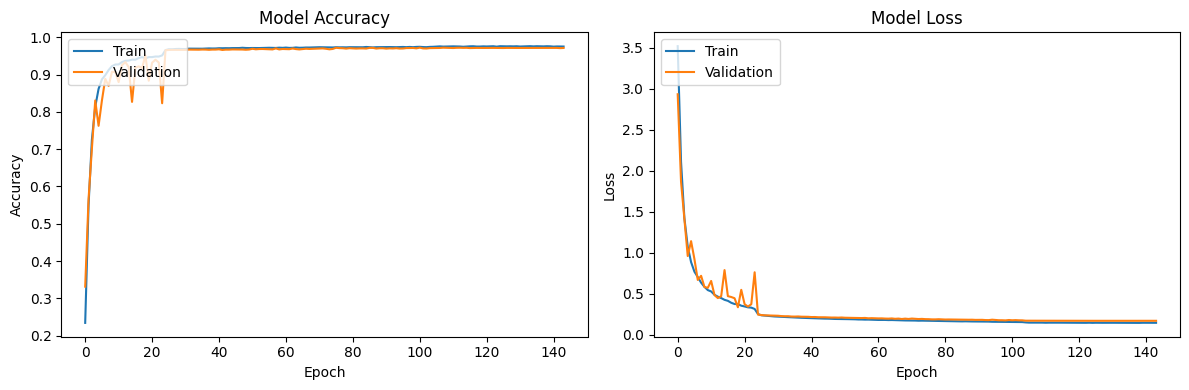

Test Loss: 0.1725
Test Accuracy: 0.9713
Top-1 Error: 0.0287
Top-5 Error: 0.0161

Classification Report:
              precision    recall  f1-score   support

    accident       1.00      0.99      0.99        98
       apple       1.00      0.99      1.00       115
         bad       1.00      0.98      0.99        63
     balance       0.97      0.94      0.95       100
         bar       0.99      0.98      0.98        95
  basketball       0.99      1.00      0.99        92
     because       1.00      1.00      1.00         1
         bed       0.99      0.97      0.98        76
      before       0.99      0.93      0.96       102
        bird       0.96      0.96      0.96        85
       black       0.98      0.94      0.96        68
     blanket       1.00      0.97      0.98        63
     bowling       1.00      1.00      1.00        76
     brother       1.00      0.97      0.98        86
        call       1.00      0.98      0.99        57
       candy       0.99      0.

In [12]:
from sklearn.metrics import top_k_accuracy_score

# Get predictions on the test set
y_pred = model.predict(X_test)

# Calculate Top-1 Error
top1_accuracy = np.mean(np.argmax(y_pred, axis=1) == np.argmax(y_test, axis=1))
top1_error = 1 - top1_accuracy

# Calculate Top-5 Error
top5_accuracy = top_k_accuracy_score(np.argmax(y_test, axis=1), y_pred, k=5)
top5_error = 1 - top5_accuracy

# If you want to plot the training history including these metrics:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

# Print final evaluation metrics
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Top-1 Error: {top1_error:.4f}")
print(f"Top-5 Error: {top5_error:.4f}")

# If you want to see per-class accuracy:
from sklearn.metrics import classification_report

y_true = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

class_report = classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_)
print("\nClassification Report:")
print(class_report)

## Results and Analysis
The proposed model achieved strong performance in sign language recognition, with the following key results:

### Performance Summary
- **Test Accuracy:** 97.13%, **Test Loss:** 0.1725  
- **Top-1 Error Rate:** 2.87%, **Top-5 Error Rate:** 1.61%  
- **Macro-Averaged Metrics:** Precision, Recall, and F1-score at 97%  
- **Weighted Averages:** Similar metrics confirming robustness despite class imbalance.

### Class-Level Observations
- High-performing classes like **"accident," "apple,"** and **"bowling"** had near-perfect scores.
- Challenges were observed in classes like **"balance"** and **"black,"** likely due to overlapping features or subtle gesture variations.

### Error Analysis
- Misclassifications were linked to rapid motion transitions or low representation of certain gestures.
- Inconsistent signing styles across samples occasionally contributed to reduced recall.

### Strengths and Limitations
- The integration of Transformer blocks and Conv1D layers allowed effective temporal and spatial feature extraction.
- Limitations include challenges with subtle or low-frequency gestures, which could benefit from targeted augmentation.

## Conclusion
The model demonstrates high accuracy and reliability, making it suitable for real-time sign language recognition. Future efforts can focus on improving performance for complex or underrepresented gestures.